In [1]:
import json
import os
import time
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import requests
from adjustText import adjust_text
from dotenv import load_dotenv
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    GBTClassifier,
    LinearSVC,
    LogisticRegression,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
    RegressionEvaluator,
)
from pyspark.ml.feature import PCA, RobustScaler, StandardScaler, VectorAssembler
from pyspark.ml.regression import (
    DecisionTreeRegressor,
    GBTRegressor,
    LinearRegression,
    RandomForestRegressor,
)
from pyspark.sql import Row, SparkSession
from sklearn.cluster import HDBSCAN

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
load_dotenv()

True

In [3]:
hadoop_bin = os.path.join(os.environ.get("HADOOP_HOME"), "bin")

if hadoop_bin not in os.environ["PATH"]:
    os.environ["PATH"] += hadoop_bin

In [4]:
def download_s3_dependencies():
    target_directory = ".venv/Lib/site-packages/pyspark/jars"
    files = [
        "https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.4/hadoop-aws-3.3.4.jar",
        "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-core/1.12.599/aws-java-sdk-core-1.12.599.jar",
        "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-s3/1.12.599/aws-java-sdk-s3-1.12.599.jar",
        "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-dynamodb/1.12.599/aws-java-sdk-dynamodb-1.12.599.jar",
    ]

    for file in files:
        filename = file.split("/")[-1]
        file_path = os.path.join(target_directory, filename)

        if os.path.exists(file_path):
            print(f"{filename} exists.")
            continue

        print(filename)
        response = requests.get(file)

        with open(file_path, "wb") as f:
            f.write(response.content)


download_s3_dependencies()

hadoop-aws-3.3.4.jar exists.
aws-java-sdk-core-1.12.599.jar exists.
aws-java-sdk-s3-1.12.599.jar exists.
aws-java-sdk-dynamodb-1.12.599.jar exists.


In [5]:
class TimeKeeper:
    def __init__(self):
        self.file = "metrics/durations.json"
        self.starts = {}

        if os.path.exists(self.file):
            with open(self.file, "r") as f:
                self.durations = json.load(f)
        else:
            self.durations = {}

    def start(self, key, overwrite=False):
        if key in self.durations and not overwrite:
            print("Enable overwrite to save the new duration.")
            return

        self.starts[key] = time.time_ns()

    def stop(self, key):
        if key not in self.starts and key not in self.durations:
            print(f"Key {key} does not exist.")
            return

        if key not in self.starts:
            return

        self.durations[key] = time.time_ns() - self.starts[key]

        with open(self.file, "w") as f:
            f.write(json.dumps(self.durations))

        del self.starts[key]

In [6]:
class MemoryKeeper:
    def __init__(self):
        self.file = "metrics/memory.json"

        if os.path.exists(self.file):
            with open(self.file, "r") as f:
                self.memory = json.load(f)
        else:
            self.memory = {}

    def record(self, key, value, overwrite=False):
        if key in self.memory and not overwrite:
            print("Enable overwrite to save the new memory usage.")
            return

        self.memory[key] = value

        with open(self.file, "w") as f:
            f.write(json.dumps(self.memory))

In [7]:
tk = TimeKeeper()
mk = MemoryKeeper()

In [8]:
spark = SparkSession.builder.getOrCreate()

In [9]:
hadoop_conf = spark._jsc.hadoopConfiguration()

hadoop_conf.set("fs.s3a.endpoint", "blizzard.inside.yjoer.com:9101")
hadoop_conf.set("fs.s3a.access.key", os.environ.get("S3_KEY"))
hadoop_conf.set("fs.s3a.secret.key", os.environ.get("S3_SECRET"))
hadoop_conf.set("fs.s3a.connection.ssl.enabled", "false")
hadoop_conf.set("fs.s3a.path.style.access", "true")

## Data Loading

In [10]:
files = [
    "s3a://datasets/renewable_energy_worldwide/01 renewable-share-energy.csv",
    "s3a://datasets/renewable_energy_worldwide/02 modern-renewable-energy-consumption.csv",
    "s3a://datasets/renewable_energy_worldwide/03 modern-renewable-prod.csv",
    "s3a://datasets/renewable_energy_worldwide/04 share-electricity-renewables.csv",
    "s3a://datasets/renewable_energy_worldwide/05 hydropower-consumption.csv",
    "s3a://datasets/renewable_energy_worldwide/06 hydro-share-energy.csv",
    "s3a://datasets/renewable_energy_worldwide/07 share-electricity-hydro.csv",
    "s3a://datasets/renewable_energy_worldwide/08 wind-generation.csv",
    "s3a://datasets/renewable_energy_worldwide/09 cumulative-installed-wind-energy-capacity-gigawatts.csv",
    "s3a://datasets/renewable_energy_worldwide/10 wind-share-energy.csv",
    "s3a://datasets/renewable_energy_worldwide/11 share-electricity-wind.csv",
    "s3a://datasets/renewable_energy_worldwide/12 solar-energy-consumption.csv",
    "s3a://datasets/renewable_energy_worldwide/13 installed-solar-PV-capacity.csv",
    "s3a://datasets/renewable_energy_worldwide/14 solar-share-energy.csv",
    "s3a://datasets/renewable_energy_worldwide/15 share-electricity-solar.csv",
    "s3a://datasets/renewable_energy_worldwide/16 biofuel-production.csv",
    "s3a://datasets/renewable_energy_worldwide/17 installed-geothermal-capacity.csv",
]

In [11]:
options = {
    "header": True,
    "inferSchema": True,
}

df_renewables = spark.read.csv(files[0], **options).cache()
df_renewables_consumption = spark.read.csv(files[1], **options).cache()
df_renewables_production = spark.read.csv(files[2], **options).cache()
df_renewables_electricity = spark.read.csv(files[3], **options).cache()

df_hydropower = spark.read.csv(files[5], **options).cache()
df_hydropower_consumption = spark.read.csv(files[4], **options).cache()
df_hydropower_electricity = spark.read.csv(files[6], **options).cache()

df_wind = spark.read.csv(files[9], **options).cache()
df_wind_production = spark.read.csv(files[7], **options).cache()
df_wind_capacity = spark.read.csv(files[8], **options).cache()
df_wind_electricity = spark.read.csv(files[10], **options).cache()

df_solar = spark.read.csv(files[13], **options).cache()
df_solar_consumption = spark.read.csv(files[11], **options).cache()
df_solar_capacity = spark.read.csv(files[12], **options).cache()
df_solar_electricity = spark.read.csv(files[14], **options).cache()

df_biofuel_production = spark.read.csv(files[15], **options).cache()
df_geothermal_capacity = spark.read.csv(files[16], **options).cache()

# df_renewables.createOrReplaceTempView("renewables")

## Data Integration

### Renewables

In [12]:
renewables_codes = [
    df_renewables.Code,
    df_renewables_consumption.Code,
    df_renewables_production.Code,
    df_renewables_electricity.Code,
]

df_renewables_joined = (
    df_renewables.join(
        other=df_renewables_consumption,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_renewables_production,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_renewables_electricity,
        on=["Entity", "Year"],
        how="outer",
    )
    .select(
        F.col("Entity"),
        F.coalesce(*renewables_codes).alias("Code"),
        F.col("Year"),
        F.col("Renewables (% equivalent primary energy)").alias("renewables_primary_share"),
        F.col("Renewables (% electricity)").alias("renewables_electricity_share"),
        F.col("Hydro Generation - TWh").alias("hydro_generation"),
        F.col("Wind Generation - TWh").alias("wind_generation"),
        F.col("Solar Generation - TWh").alias("solar_generation"),
        F.col("Geo Biomass Other - TWh").alias("other_generation"),
        F.col("Electricity from hydro (TWh)").alias("hydro_electricity"),
        F.col("Electricity from wind (TWh)").alias("wind_electricity"),
        F.col("Electricity from solar (TWh)").alias("solar_electricity"),
        F.col("Other renewables including bioenergy (TWh)").alias("other_electricity"),
    )
    .cache()
)  # fmt: skip

In [13]:
df_renewables_joined.count()

8851

In [14]:
df_renewables_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



### Hydropower

In [15]:
hydropower_codes = [
    df_hydropower.Code,
    df_hydropower_consumption.Code,
    df_hydropower_electricity.Code,
]

df_hydropower_joined = (
    df_hydropower.join(
        other=df_hydropower_consumption,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_hydropower_electricity,
        on=["Entity", "Year"],
        how="outer",
    )
    .select(
        F.col("Entity"),
        F.coalesce(*hydropower_codes).alias("Code"),
        F.col("Year"),
        F.col("Hydro (% equivalent primary energy)").alias("hydro_primary_share"),
        F.col("Electricity from hydro (TWh)").alias("hydro_electricity"),
        F.col("Hydro (% electricity)").alias("hydro_electricity_share"),
    )
    .cache()
)

In [16]:
df_hydropower_joined.count()

8840

In [17]:
df_hydropower_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



### Wind Power

In [18]:
wind_codes = [
    df_wind.Code,
    df_wind_production.Code,
    df_wind_capacity.Code,
    df_wind_electricity.Code,
]

df_wind_joined = (
    df_wind.join(other=df_wind_production, on=["Entity", "Year"], how="outer")
    .join(other=df_wind_capacity, on=["Entity", "Year"], how="outer")
    .join(other=df_wind_electricity, on=["Entity", "Year"], how="outer")
    .select(
        F.col("Entity"),
        F.coalesce(*wind_codes).alias("Code"),
        F.col("Year"),
        F.col("Wind (% equivalent primary energy)").alias("wind_primary_share"),
        F.col("Electricity from wind (TWh)").alias("wind_electricity"),
        F.col("Wind Capacity").alias("wind_capacity"),
        F.col("Wind (% electricity)").alias("wind_electricity_share"),
    )
    .cache()
)

In [19]:
df_wind_joined.count()

8685

In [20]:
df_wind_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



### Solar Power

In [21]:
solar_codes = [
    df_solar.Code,
    df_solar_consumption.Code,
    df_solar_capacity.Code,
    df_solar_electricity.Code,
]

df_solar_joined = (
    df_solar.join(other=df_solar_consumption, on=["Entity", "Year"], how="outer")
    .join(other=df_solar_capacity, on=["Entity", "Year"], how="outer")
    .join(other=df_solar_electricity, on=["Entity", "Year"], how="outer")
    .select(
        F.col("Entity"),
        F.coalesce(*solar_codes).alias("Code"),
        F.col("Year"),
        F.col("Solar (% equivalent primary energy)").alias("solar_primary_share"),
        F.col("Electricity from solar (TWh)").alias("solar_electricity"),
        F.col("Solar Capacity").alias("solar_capacity"),
        F.col("Solar (% electricity)").alias("solar_electricity_share"),
    )
    .cache()
)

In [22]:
df_solar_joined.count()

8691

In [23]:
df_solar_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



### Others

In [24]:
others_codes = [
    df_biofuel_production.Code,
    df_geothermal_capacity.Code,
]

df_others_joined = (
    df_biofuel_production.join(
        other=df_geothermal_capacity,
        on=["Entity", "Year"],
        how="outer",
    )
    .select(
        F.col("Entity"),
        F.coalesce(*others_codes).alias("Code"),
        F.col("Year"),
        F.col("Biofuels Production - TWh - Total").alias("biofuel_generation"),
        F.col("Geothermal Capacity").alias("geothermal_capacity"),
    )
    .cache()
)

In [25]:
df_others_joined.count()

1634

In [26]:
df_others_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



### Amalgamation

In [27]:
codes = [
    df_renewables_joined.Code,
    df_hydropower_joined.Code,
    df_wind_joined.Code,
    df_solar_joined.Code,
    df_others_joined.Code,
]

hydro_electricity = [
    df_renewables_joined.hydro_electricity,
    df_hydropower_joined.hydro_electricity,
]

wind_electricity = [
    df_renewables_joined.wind_electricity,
    df_wind_joined.wind_electricity,
]

solar_electricity = [
    df_renewables_joined.solar_electricity,
    df_solar_joined.solar_electricity,
]

df_joined = (
    df_renewables_joined.join(
        other=df_hydropower_joined,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_wind_joined,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_solar_joined,
        on=["Entity", "Year"],
        how="outer",
    )
    .join(
        other=df_others_joined,
        on=["Entity", "Year"],
        how="outer",
    )
    .select(
        F.col("Entity"),
        F.coalesce(*codes).alias("Code"),
        F.col("Year"),
        #
        F.col("renewables_primary_share"),
        F.col("renewables_electricity_share"),
        F.col("hydro_generation"),
        F.col("wind_generation"),
        F.col("solar_generation"),
        F.col("other_generation"),
        F.col("other_electricity"),
        #
        F.col("hydro_primary_share"),
        F.col("hydro_electricity_share"),
        F.coalesce(*hydro_electricity).alias("hydro_electricity"),
        #
        F.col("wind_primary_share"),
        F.col("wind_electricity_share"),
        F.coalesce(*wind_electricity).alias("wind_electricity"),
        F.col("wind_capacity"),
        #
        F.col("solar_primary_share"),
        F.col("solar_electricity_share"),
        F.coalesce(*solar_electricity).alias("solar_electricity"),
        F.col("solar_capacity"),
        #
        F.col("biofuel_generation"),
        F.col("geothermal_capacity"),
    )
    .orderBy(["Entity", "Year"])
    .cache()
)

In [28]:
df_joined.count()

8997

In [29]:
df_joined.groupBy("Entity", "Year").count().filter(F.col("count") > 1).show()

+------+----+-----+
|Entity|Year|count|
+------+----+-----+
+------+----+-----+



In [30]:
df_joined.filter("Year < 1965 OR Year > 2022").count()

0

In [31]:
df_joined.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- renewables_primary_share: double (nullable = true)
 |-- renewables_electricity_share: double (nullable = true)
 |-- hydro_generation: double (nullable = true)
 |-- wind_generation: double (nullable = true)
 |-- solar_generation: double (nullable = true)
 |-- other_generation: double (nullable = true)
 |-- other_electricity: double (nullable = true)
 |-- hydro_primary_share: double (nullable = true)
 |-- hydro_electricity_share: double (nullable = true)
 |-- hydro_electricity: double (nullable = true)
 |-- wind_primary_share: double (nullable = true)
 |-- wind_electricity_share: double (nullable = true)
 |-- wind_electricity: double (nullable = true)
 |-- wind_capacity: double (nullable = true)
 |-- solar_primary_share: double (nullable = true)
 |-- solar_electricity_share: double (nullable = true)
 |-- solar_electricity: double (nullable = true)
 |-- solar_capacity: 

In [32]:
df_joined.toPandas()

,Entity,Code,Year,renewables_primary_share,renewables_electricity_share,hydro_generation,wind_generation,solar_generation,other_generation,other_electricity,...,wind_primary_share,wind_electricity_share,wind_electricity,wind_capacity,solar_primary_share,solar_electricity_share,solar_electricity,solar_capacity,biofuel_generation,geothermal_capacity
0,Afghanistan,AFG,2000,NaN,65.957440,NaN,NaN,NaN,NaN,0.00,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.00,NaN,NaN,NaN
1,Afghanistan,AFG,2001,NaN,84.745766,NaN,NaN,NaN,NaN,0.00,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.00,NaN,NaN,NaN
2,Afghanistan,AFG,2002,NaN,81.159424,NaN,NaN,NaN,NaN,0.00,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.00,NaN,NaN,NaN
3,Afghanistan,AFG,2003,NaN,67.021280,NaN,NaN,NaN,NaN,0.00,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.00,NaN,NaN,NaN
4,Afghanistan,AFG,2004,NaN,62.921350,NaN,NaN,NaN,NaN,0.00,...,NaN,0.0,0.0,NaN,NaN,0.000000,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8992,Zimbabwe,ZWE,2017,NaN,58.503407,NaN,NaN,NaN,NaN,0.32,...,NaN,0.0,0.0,NaN,NaN,0.136054,0.01,NaN,NaN,NaN
8993,Zimbabwe,ZWE,2018,NaN,59.412407,NaN,NaN,NaN,NaN,0.39,...,NaN,0.0,0.0,NaN,NaN,0.217628,0.02,NaN,NaN,NaN
8994,Zimbabwe,ZWE,2019,NaN,55.582527,NaN,NaN,NaN,NaN,0.38,...,NaN,0.0,0.0,NaN,NaN,0.364078,0.03,NaN,NaN,NaN
8995,Zimbabwe,ZWE,2020,NaN,55.131580,NaN,NaN,NaN,NaN,0.35,...,NaN,0.0,0.0,NaN,NaN,0.394737,0.03,NaN,NaN,NaN


In [33]:
df_joined.select(*(F.skewness(col) for col in df_joined.columns[3:])).toPandas()

,skewness(renewables_primary_share),skewness(renewables_electricity_share),skewness(hydro_generation),skewness(wind_generation),skewness(solar_generation),skewness(other_generation),skewness(other_electricity),skewness(hydro_primary_share),skewness(hydro_electricity_share),skewness(hydro_electricity),skewness(wind_primary_share),skewness(wind_electricity_share),skewness(wind_electricity),skewness(wind_capacity),skewness(solar_primary_share),skewness(solar_electricity_share),skewness(solar_electricity),skewness(solar_capacity),skewness(biofuel_generation),skewness(geothermal_capacity)
0,2.233821,0.920404,4.839383,9.74169,12.516026,6.848907,6.848729,2.285338,1.139959,5.286317,6.726212,6.397387,9.889489,5.870303,5.522441,7.163254,12.627061,7.828298,4.072647,3.808404


In [34]:
countries = (
    df_joined.filter("Code IS NOT NULL")
    .select("Entity")
    .distinct()
    .rdd.flatMap(lambda x: x)
    .collect()
)

print(countries)

['Chad', 'Paraguay', 'Russia', 'Macao', 'World', 'Yemen', 'Senegal', 'Sweden', 'Kiribati', 'Guyana', 'Eritrea', 'Philippines', 'Djibouti', 'Tonga', 'Malaysia', 'Singapore', 'Fiji', 'Turkey', 'United States Virgin Islands', 'Malawi', 'Western Sahara', 'Iraq', 'Germany', 'Comoros', 'Afghanistan', 'Cambodia', 'Jordan', 'Maldives', 'Rwanda', 'Saint Helena', 'Sudan', 'France', 'Turks and Caicos Islands', 'Greece', 'Kosovo', 'Sri Lanka', 'Montserrat', 'British Virgin Islands', 'Dominica', 'Taiwan', 'Algeria', 'Equatorial Guinea', 'Togo', 'Slovakia', 'Reunion', 'Argentina', 'Angola', 'Belgium', 'Ecuador', 'Qatar', 'Lesotho', 'Albania', 'Madagascar', 'Finland', 'New Caledonia', 'Ghana', 'Myanmar', 'Nicaragua', 'Benin', 'Peru', 'Sierra Leone', 'Bahamas', 'China', 'India', 'United States', 'Belarus', 'American Samoa', 'Kuwait', 'Malta', 'Sao Tome and Principe', 'Somalia', 'Chile', 'Puerto Rico', 'Tajikistan', 'Martinique', 'Cayman Islands', 'Croatia', 'Burundi', 'Bolivia', 'Nigeria', 'Gabon', 'I

In [35]:
regions = (
    df_joined.filter("Code IS NULL")
    .select("Entity")
    .distinct()
    .rdd.flatMap(lambda x: x)
    .collect()
)

print(regions)

['European Union (27) (Ember)', 'Oceania (Ember)', 'Africa (Ember)', 'Europe', 'High-income countries', 'Africa', 'G20 (Ember)', 'Middle Africa (BP)', 'Western Africa (BP)', 'Non-OECD (BP)', 'Latin America and Caribbean (Ember)', 'Middle East (BP)', 'OECD (Ember)', 'Europe (BP)', 'South & Central America', 'North America', 'Asia Pacific (BP)', 'Europe (Ember)', 'Asia (Ember)', 'Low-income countries', 'South and Central America (BP)', 'Africa (BP)', 'South America', 'Upper-middle-income countries', 'G7 (Ember)', 'North America (Ember)', 'North America (BP)', 'Other Europe', 'European Union (27)', 'Oceania', 'OECD (BP)', 'CIS', 'CIS (BP)', 'Central America (BP)', 'Asia', 'Eastern Africa (BP)', 'Asia Pacific', 'Other South & Central America', 'Lower-middle-income countries']


## PCA and Clustering

### Data Preprocessing

In [36]:
def preprocess_pca(fit):
    df_joined_filled = df_joined.fillna(-1)
    features = df_joined_filled.columns[3:]

    if fit:
        assembler_stages = [
            VectorAssembler(inputCols=[feature], outputCol=f"{feature}_vt")
            for feature in features
        ]

        scaler_stages = [
            StandardScaler(
                inputCol=f"{feature}_vt",
                outputCol=f"{feature}_scaled",
                withMean=True,
                withStd=True,
            )
            for feature in features
        ]

        pipeline = Pipeline(stages=assembler_stages + scaler_stages)
        model = pipeline.fit(df_joined_filled)
        model.write().overwrite().save("models/preprocess_pca")
    else:
        model = PipelineModel.load("models/preprocess_pca")

    return model.transform(df_joined_filled).drop(
        *features,
        *[f"{feature}_vt" for feature in features],
    )

In [37]:
df_joined_filled_scaled = preprocess_pca(fit=False)

In [38]:
def create_pca_padding():
    features = df_joined.columns[3:]
    model = PipelineModel.load("models/preprocess_pca")

    row = Row(*features)
    df = spark.createDataFrame([row(*[-1] * 20)])

    return (
        model.transform(df)
        .drop(*features, *[f"{feature}_vt" for feature in features])
        .rdd.map(lambda row: [float(v[0]) for v in row])
        .first()
    )

In [39]:
def create_pca_dataframe():
    rows = []

    current_country = None
    current_year = 1965
    current_row = []

    padding = create_pca_padding()

    def save_row():
        nonlocal current_year

        # Handle cases where years were missing when departing from a country.
        while current_year != 2023:
            current_row.extend(padding)
            current_year += 1

        rows.append(current_row)

    for row in df_joined_filled_scaled.rdd.toLocalIterator():
        country = row[0]
        year = row[2]

        if country != current_country:
            # Save the vector when moving from one country to another.
            if current_country is not None:
                save_row()

            # Reset current trackers.
            current_country = country
            current_year = 1965
            current_row = [country]

        # Fill in -1 for all features for missing years.
        while year != current_year:
            current_row.extend(padding)
            current_year += 1

        for idx, v in enumerate(row):
            if idx < 3:
                continue

            current_row.append(float(v[0]))

        current_year = year + 1

    save_row()

    return spark.createDataFrame(rows, ["Entity"])


pca_df = create_pca_dataframe()

### Modelling

#### PCA

In [40]:
def train_pca(fit):
    features = pca_df.columns[1:]

    if fit:
        stages = [
            VectorAssembler(inputCols=features, outputCol="pca_features"),
            PCA(k=2, inputCol="pca_features", outputCol="pca"),
        ]

        pipeline = Pipeline(stages=stages)

        tk.start("pca")
        tracemalloc.start()

        model = pipeline.fit(pca_df)

        mk.record("pca", tracemalloc.get_traced_memory()[1])
        tk.stop("pca")
        tracemalloc.stop()

        model.write().overwrite().save("models/pca")
    else:
        model = PipelineModel.load("models/pca")

    return model.transform(pca_df).drop(*features, "pca_features")

In [41]:
pca = train_pca(fit=False)

pca_pd = pca.toPandas()
pca_pd[["PC1", "PC2"]] = pd.DataFrame(pca_pd.pca.tolist())
pca_pd.drop("pca", axis=1, inplace=True)

#### Clustering

In [42]:
tk.start("hdbscan")
tracemalloc.start()

hdb = HDBSCAN(cluster_selection_epsilon=3.5)
clusters = hdb.fit_predict(pca_pd[["PC1", "PC2"]])

mk.record("hdbscan", tracemalloc.get_traced_memory()[1])
tk.stop("hdbscan")
tracemalloc.stop()

pca_pd["cluster"] = pd.Series(clusters)

### Visualization

In [43]:
def plot_clustered_pca(show_outliers=False, show_local=False):
    plt.figure(figsize=(10, 4.8))

    for cluster in np.sort(pca_pd.cluster.unique()):
        filter = pca_pd.cluster == cluster
        x = pca_pd[filter]["PC1"]
        y = pca_pd[filter]["PC2"]

        if cluster == -1:
            label = "Outliers"
        else:
            label = f"Cluster {cluster}"

        plt.scatter(x, y, label=label)

    annotations = []

    if show_outliers:
        for idx, row in pca_pd[pca_pd.cluster == -1].iterrows():
            plt.annotate(row.Entity, (row.PC1 + 2, row.PC2 + 1))

    if show_local:
        areas = [
            "Malaysia",
            "Thailand",
            "Singapore",
            "Brunei",
            "Indonesia",
            "Philippines",
            "Vietnam",
        ]

        for idx, row in pca_pd[pca_pd.Entity.isin(areas)].iterrows():
            annotations.append(plt.annotate(row.Entity, (row.PC1, row.PC2)))

    if len(annotations) > 0:
        arrowprops = dict(arrowstyle="->", color="tab:blue", lw=1)
        adjust_text(annotations, arrowprops=arrowprops, lim=1000)

    plt.title("Principal Components of the Renewable Energy Adoption Strategies")
    plt.ylabel("PC2")
    plt.xlabel("PC1")
    plt.legend()
    plt.show()

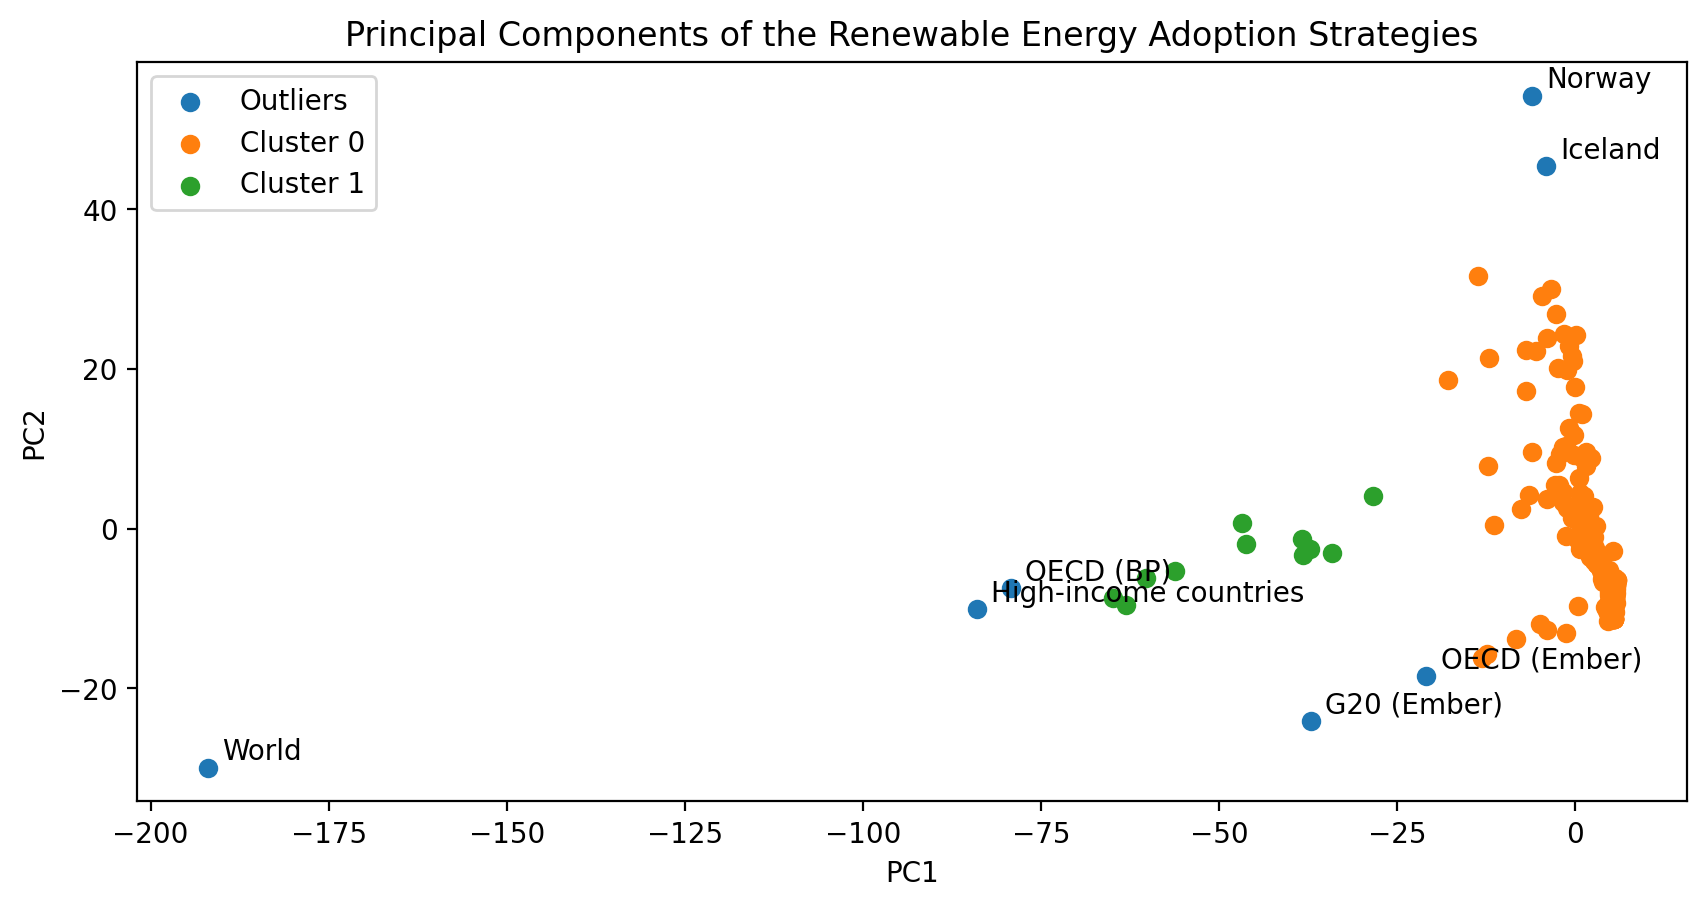

In [44]:
plot_clustered_pca(show_outliers=True)

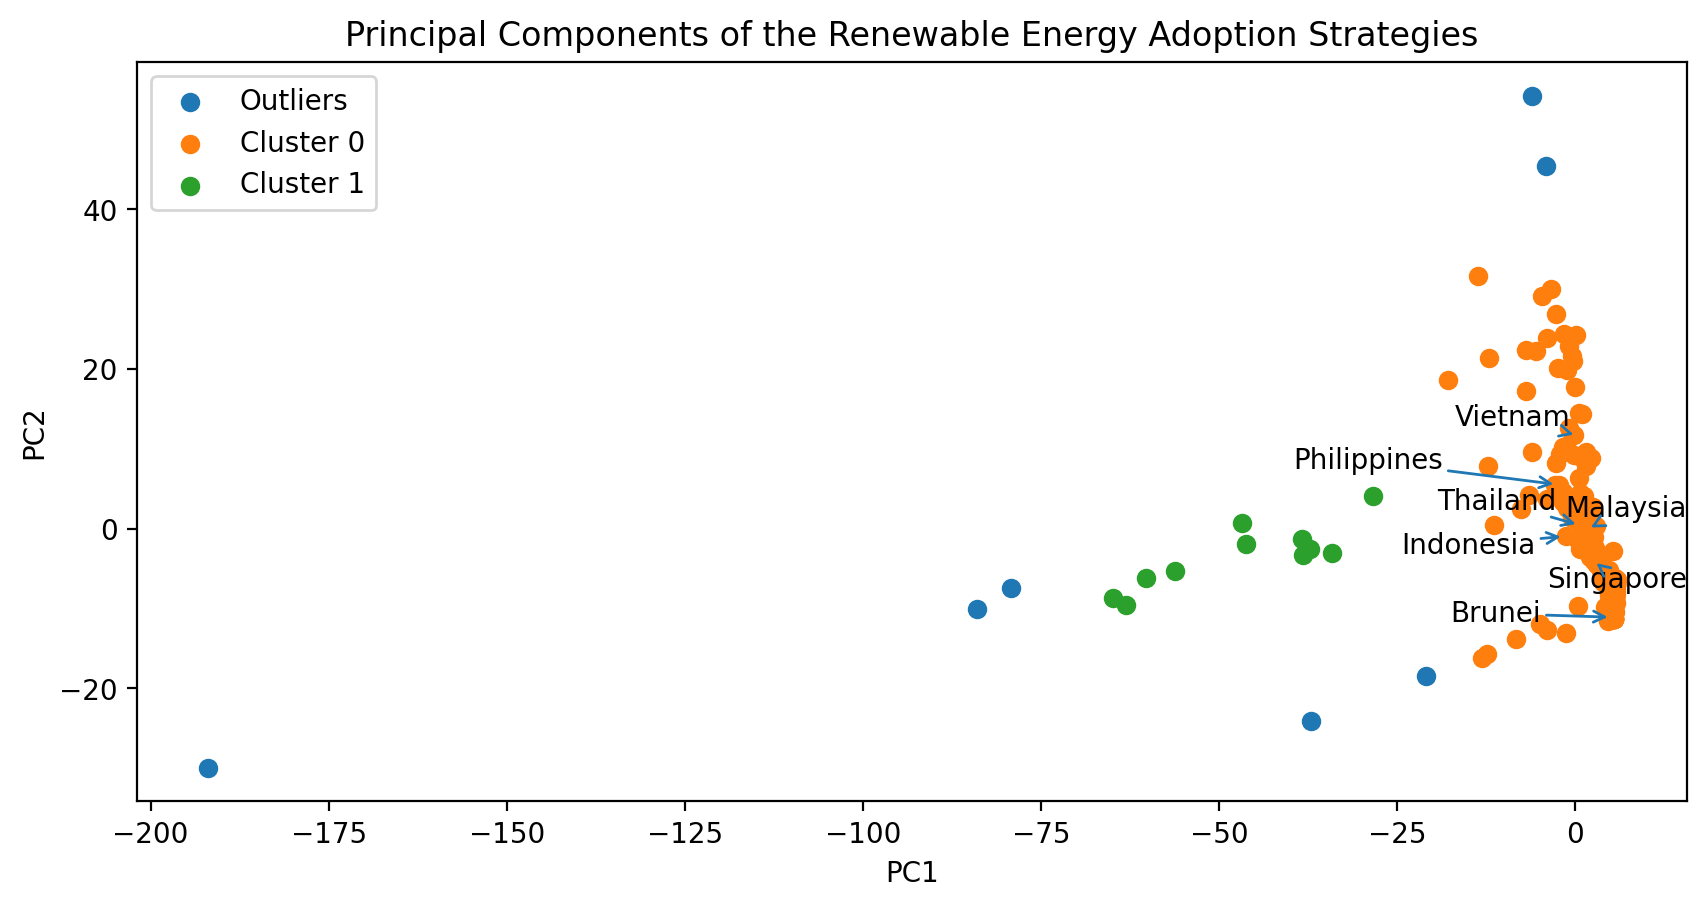

In [45]:
plot_clustered_pca(show_local=True)

## CO2 Emissions

### Data Loading

In [46]:
emissions_file = "s3a://datasets/co2_emissions/co2_emissions_kt_by_country.csv"

df_emissions = spark.read.csv(emissions_file, **options).cache()

### Data Cleaning

In [47]:
country_name_map = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Congo, Dem. Rep.": "Democratic Republic of Congo",
    "Congo, Rep.": "Congo",
    "Egypt, Arab Rep.": "Egypt",
    "Faroe Islands": "Faeroe Islands",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macao",
    "Russian Federation": "Russia",
    "Slovak Republic": "Slovakia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Lucia": "Saint Lucia",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "Timor",
    "Venezuela, RB": "Venezuela",
    "Yemen, Rep.": "Yemen",
}

df_emissions_fixed = df_emissions.replace(country_name_map, subset="country_name")

In [48]:
countries_emissions = (
    df_emissions_fixed.select("country_name")
    .distinct()
    .rdd.map(lambda x: x[0])
    .collect()
)

In [49]:
# Countries without emissions data
countries_no_emissions = sorted(set(countries).difference(set(countries_emissions)))
print(countries_no_emissions)

['American Samoa', 'Cook Islands', 'Falkland Islands', 'French Guiana', 'Guadeloupe', 'Guam', 'Martinique', 'Montserrat', 'Niue', 'Palestine', 'Puerto Rico', 'Reunion', 'Saint Helena', 'Saint Pierre and Miquelon', 'Taiwan', 'USSR', 'United States Virgin Islands', 'Western Sahara']


### Data Integration

In [50]:
df_joined_emissions = (
    df_joined.join(
        other=df_emissions_fixed,
        on=(df_joined.Entity == df_emissions_fixed.country_name)
        & (df_joined.Year == df_emissions_fixed.year),
        how="left",
    )
    .drop(
        df_emissions_fixed.country_name,
        df_emissions_fixed.country_code,
        df_emissions_fixed.year,
    )
    .withColumnRenamed("value", "emissions")
    .cache()
)

### Data Formatting

In [51]:
df_joined_emissions_filled = df_joined_emissions.filter("emissions IS NOT NULL").fillna(-1)  # fmt: skip

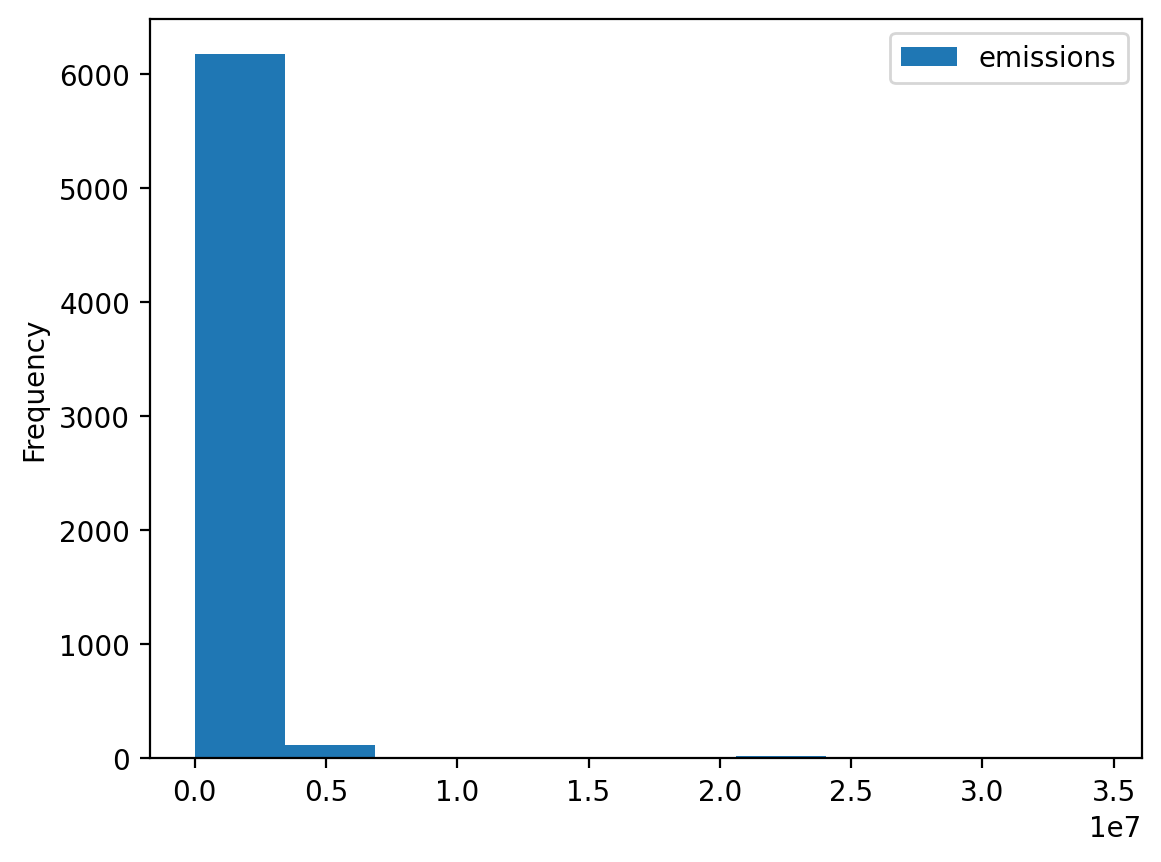

In [52]:
df_joined_emissions_filled.select("emissions").toPandas().plot.hist()
plt.show()

In [53]:
df_joined_emissions_filled.select(F.skewness("emissions")).show()

+-------------------+
|skewness(emissions)|
+-------------------+
|  9.831035906900127|
+-------------------+



In [54]:
emissions_median = (
    df_joined_emissions_filled.select(F.median("emissions"))
    .rdd.flatMap(lambda x: x)
    .first()
)

emissions_median

26490.0

In [55]:
df_joined_emissions_filled_low = df_joined_emissions_filled.filter(
    F.col("emissions") <= emissions_median
).withColumn("emissions_category", F.lit(0))

df_joined_emissions_filled_high = df_joined_emissions_filled.filter(
    F.col("emissions") > emissions_median
).withColumn("emissions_category", F.lit(1))

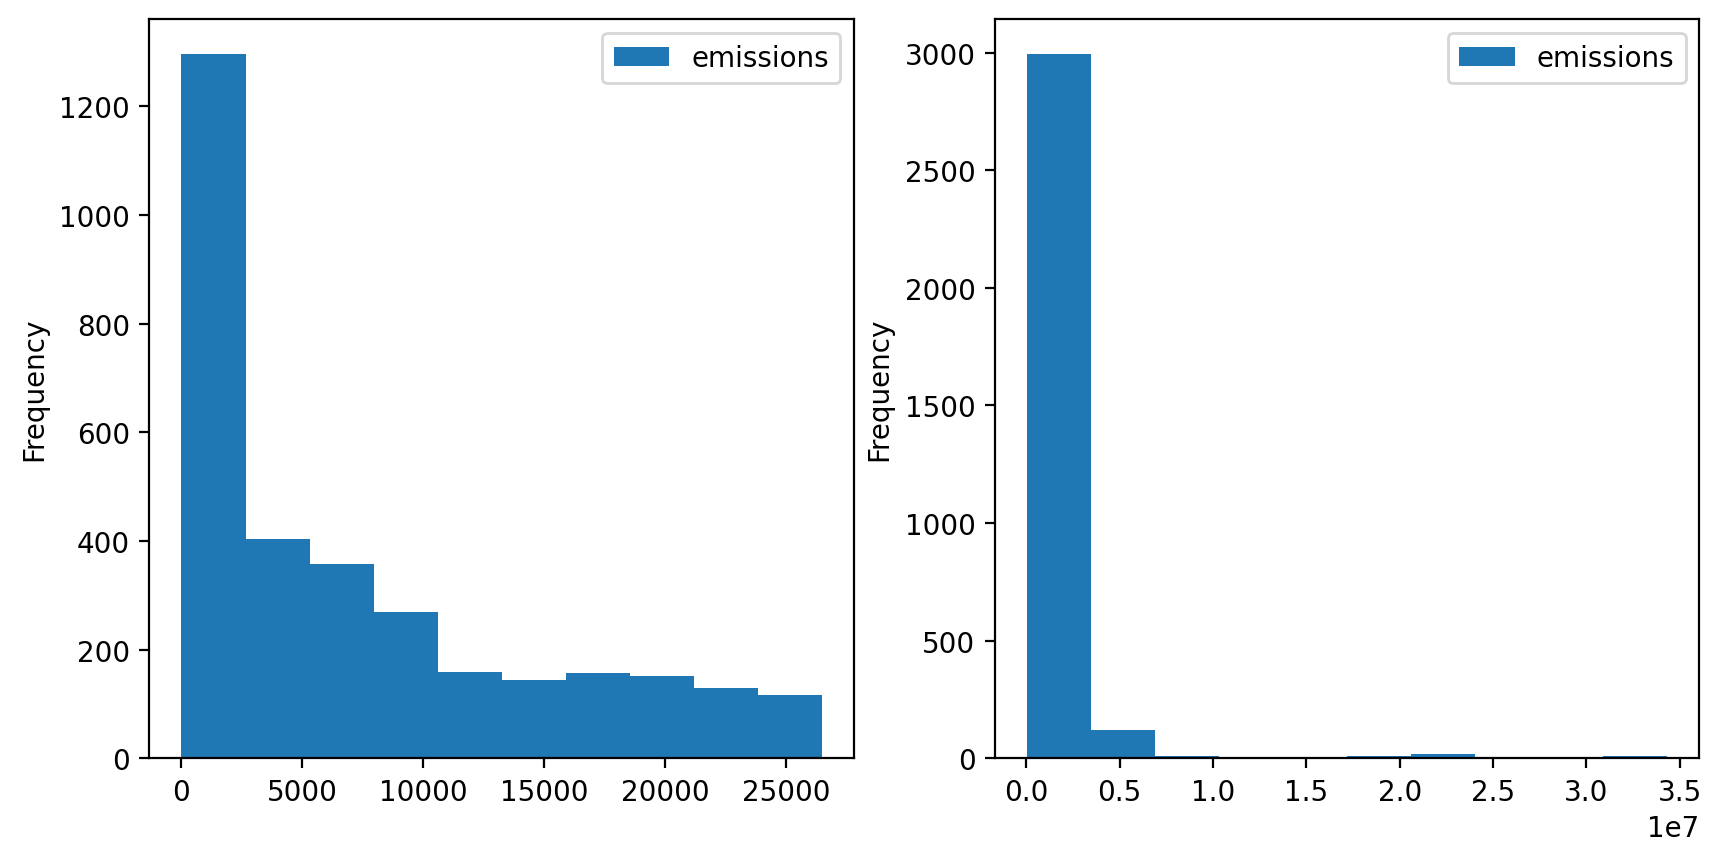

In [56]:
fig = plt.figure(figsize=(10, 4.8))

ax1 = fig.add_subplot(121)
df_joined_emissions_filled_low.select("emissions").toPandas().plot.hist(ax=ax1)

ax2 = fig.add_subplot(122)
df_joined_emissions_filled_high.select("emissions").toPandas().plot.hist(ax=ax2)

plt.show()

In [57]:
df_joined_emissions_filled_low.select(F.skewness("emissions")).show()
df_joined_emissions_filled_high.select(F.skewness("emissions")).show()

+-------------------+
|skewness(emissions)|
+-------------------+
| 0.9814892688116862|
+-------------------+

+-------------------+
|skewness(emissions)|
+-------------------+
|  6.906857112206797|
+-------------------+



In [58]:
# For the regression task in the second stage.
train_emissions_low, test_emissions_low = df_joined_emissions_filled_low.randomSplit(
    [0.8, 0.2],
    seed=12345,
)

train_emissions_high, test_emissions_high = df_joined_emissions_filled_high.randomSplit(
    [0.8, 0.2],
    seed=12345,
)

# For the classification task in the first stage and end-to-end multi-stage tasks.
train_emissions = train_emissions_low.union(train_emissions_high)
test_emissions = test_emissions_low.union(test_emissions_high)

In [59]:
def preprocess_emissions_input(name, df, fit=False):
    features = df.columns[3:23]

    if fit:
        assemblers_1 = [
            VectorAssembler(inputCols=[feature], outputCol=f"{feature}_vt")
            for feature in features
        ]

        scalers = [
            RobustScaler(
                inputCol=f"{feature}_vt",
                outputCol=f"{feature}_scaled",
                withCentering=True,
                withScaling=True,
            )
            for feature in features
        ]

        assemblers_2 = [
            VectorAssembler(
                inputCols=[f"{feature}_scaled" for feature in features],
                outputCol="features",
            ),
        ]

        pipeline = Pipeline(stages=assemblers_1 + scalers + assemblers_2)
        model = pipeline.fit(df)
        model.write().overwrite().save(f"models/{name}")
    else:
        model = PipelineModel.load(f"models/{name}")

    return (
        model.transform(df)
        .withColumn("emissions", F.log1p("emissions"))
        .drop(
            *features,
            *[f"{feature}_vt" for feature in features],
            *[f"{feature}_scaled" for feature in features],
        )
    )

In [60]:
train_emissions_low_t = preprocess_emissions_input(
    "preprocess_emissions_input_low",
    train_emissions_low,
    # fit=True
)

train_emissions_high_t = preprocess_emissions_input(
    "preprocess_emissions_input_high",
    train_emissions_high,
    # fit=True
)

train_emissions_t = preprocess_emissions_input(
    "preprocess_emissions_input",
    train_emissions,
    # fit=True
)

In [61]:
test_emissions_low_t = preprocess_emissions_input(
    "preprocess_emissions_input_low",
    test_emissions_low,
)

test_emissions_high_t = preprocess_emissions_input(
    "preprocess_emissions_input_high",
    test_emissions_high,
)

test_emissions_t = preprocess_emissions_input(
    "preprocess_emissions_input",
    test_emissions,
)

### Modelling

#### Stage 1: Classification

In [62]:
logreg_emissions = LogisticRegression(
    featuresCol="features",
    labelCol="emissions_category",
)
logreg_emissions_model = logreg_emissions.fit(train_emissions_t)

In [63]:
logreg_emissions_predictions = (
    logreg_emissions_model.transform(test_emissions_t)
    .withColumnRenamed("rawPrediction", "category_pred_raw")
    .withColumnRenamed("probability", "category_pred_proba")
    .withColumnRenamed("prediction", "category_pred")
)

In [64]:
svc_emissions = LinearSVC(featuresCol="features", labelCol="emissions_category")
svc_emissions_model = svc_emissions.fit(train_emissions_t)

In [65]:
svc_emissions_predictions = (
    svc_emissions_model.transform(test_emissions_t)
    .withColumnRenamed("rawPrediction", "category_pred_raw")
    .withColumnRenamed("probability", "category_pred_proba")
    .withColumnRenamed("prediction", "category_pred")
)

In [66]:
dtc_emissions = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="emissions_category",
)
dtc_emissions_model = dtc_emissions.fit(train_emissions_t)

In [67]:
dtc_emissions_predictions = (
    dtc_emissions_model.transform(test_emissions_t)
    .withColumnRenamed("rawPrediction", "category_pred_raw")
    .withColumnRenamed("probability", "category_pred_proba")
    .withColumnRenamed("prediction", "category_pred")
)

In [68]:
rfc_emissions = RandomForestClassifier(
    featuresCol="features",
    labelCol="emissions_category",
)
rfc_emissions_model = rfc_emissions.fit(train_emissions_t)

In [69]:
rfc_emissions_predictions = (
    rfc_emissions_model.transform(test_emissions_t)
    .withColumnRenamed("rawPrediction", "category_pred_raw")
    .withColumnRenamed("probability", "category_pred_proba")
    .withColumnRenamed("prediction", "category_pred")
)

In [70]:
gbtc_emissions = GBTClassifier(featuresCol="features", labelCol="emissions_category")
gbtc_emissions_model = gbtc_emissions.fit(train_emissions_t)

In [71]:
gbtc_emissions_predictions = (
    gbtc_emissions_model.transform(test_emissions_t)
    .withColumnRenamed("rawPrediction", "category_pred_raw")
    .withColumnRenamed("probability", "category_pred_proba")
    .withColumnRenamed("prediction", "category_pred")
)

#### Stage 2: Regression

In [72]:
def train_linear_regression_emissions(train_set, variant):
    name = f"linear_regression_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    lr = LinearRegression(featuresCol="features", labelCol="emissions")
    lr_model = lr.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return lr_model

In [73]:
def train_lasso_emissions(train_set, variant):
    name = f"lasso_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    lasso = LinearRegression(
        featuresCol="features",
        labelCol="emissions",
        elasticNetParam=1.0,
        regParam=0.3,
    )
    lasso_model = lasso.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return lasso_model

In [74]:
def train_ridge_emissions(train_set, variant):
    name = f"ridge_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    ridge = LinearRegression(
        featuresCol="features",
        labelCol="emissions",
        elasticNetParam=0.0,
        regParam=7.5,
    )
    ridge_model = ridge.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return ridge_model

In [75]:
def train_decision_tree_emissions(train_set, variant):
    name = f"decision_tree_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    dt = DecisionTreeRegressor(featuresCol="features", labelCol="emissions", seed=12345)
    dt_model = dt.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return dt_model

In [76]:
def train_random_forest_emissions(train_set, variant):
    name = f"random_forest_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    rf = RandomForestRegressor(featuresCol="features", labelCol="emissions", seed=12345)
    rf_model = rf.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return rf_model

In [77]:
def train_gbt_emissions(train_set, variant):
    name = f"gradient_boosted_tree_emissions_{variant}"
    tk.start(name)
    tracemalloc.start()

    gbt = GBTRegressor(featuresCol="features", labelCol="emissions", seed=12345)
    gbt_model = gbt.fit(train_set)

    mk.record(name, tracemalloc.get_traced_memory()[1])
    tk.stop(name)
    tracemalloc.stop()

    return gbt_model

In [78]:
lr_emissions_low = train_linear_regression_emissions(train_emissions_low_t, "low")
lr_emissions_high = train_linear_regression_emissions(train_emissions_high_t, "high")

In [79]:
lasso_emissions_low = train_lasso_emissions(train_emissions_low_t, "low")
lasso_emissions_high = train_lasso_emissions(train_emissions_high_t, "high")

In [80]:
ridge_emissions_low = train_ridge_emissions(train_emissions_low_t, "low")
ridge_emissions_high = train_ridge_emissions(train_emissions_high_t, "high")

In [81]:
dt_emissions_low = train_decision_tree_emissions(train_emissions_low_t, "low")
dt_emissions_high = train_decision_tree_emissions(train_emissions_high_t, "high")

In [82]:
rf_emissions_low = train_random_forest_emissions(train_emissions_low_t, "low")
rf_emissions_high = train_random_forest_emissions(train_emissions_high_t, "high")

In [83]:
gbt_emissions_low = train_gbt_emissions(train_emissions_low_t, "low")
gbt_emissions_high = train_gbt_emissions(train_emissions_high_t, "high")

In [84]:
def predict_emissions(model, test_set):
    return (
        model.transform(test_set)
        .withColumn("emissions", F.expm1("emissions"))
        .withColumn("prediction", F.expm1("prediction"))
    )

In [85]:
lr_emissions_low_pred = predict_emissions(lr_emissions_low, test_emissions_low_t)
lr_emissions_high_pred = predict_emissions(lr_emissions_high, test_emissions_high_t)

In [86]:
lasso_emissions_low_pred = predict_emissions(lasso_emissions_low, test_emissions_low_t)
lasso_emissions_high_pred = predict_emissions(lasso_emissions_high, test_emissions_high_t)  # fmt: skip

In [87]:
ridge_emissions_low_pred = predict_emissions(ridge_emissions_low, test_emissions_low_t)
ridge_emissions_high_pred = predict_emissions(ridge_emissions_high, test_emissions_high_t)  # fmt: skip

In [88]:
dt_emissions_low_pred = predict_emissions(dt_emissions_low, test_emissions_low_t)
dt_emissions_high_pred = predict_emissions(dt_emissions_high, test_emissions_high_t)

In [89]:
rf_emissions_low_pred = predict_emissions(rf_emissions_low, test_emissions_low_t)
rf_emissions_high_pred = predict_emissions(rf_emissions_high, test_emissions_high_t)

In [90]:
gbt_emissions_low_pred = predict_emissions(gbt_emissions_low, test_emissions_low_t)
gbt_emissions_high_pred = predict_emissions(gbt_emissions_high, test_emissions_high_t)

#### End-to-End Predictions

In [91]:
# Include the predicted category in the test set.
test_emissions_pred = test_emissions.join(
    other=gbtc_emissions_predictions.select("Entity", "Year", "category_pred"),
    on=["Entity", "Year"],
    how="inner",
)

In [92]:
# Preprocess the input according to the regression models (low/high).
test_emissions_pred_low = test_emissions_pred.filter("category_pred == 0")
test_emissions_pred_high = test_emissions_pred.filter("category_pred == 1")

test_emissions_pred_low_t = preprocess_emissions_input(
    "preprocess_emissions_input_low",
    test_emissions_pred_low,
)

test_emissions_pred_high_t = preprocess_emissions_input(
    "preprocess_emissions_input_high",
    test_emissions_pred_high,
)

In [93]:
lr_emissions_low_fp = predict_emissions(lr_emissions_low, test_emissions_pred_low_t)
lr_emissions_high_fp = predict_emissions(lr_emissions_high, test_emissions_pred_high_t)

lr_emissions_fp = lr_emissions_low_fp.union(lr_emissions_high_fp)

In [94]:
lasso_emissions_low_fp = predict_emissions(lasso_emissions_low, test_emissions_pred_low_t)  # fmt: skip
lasso_emissions_high_fp = predict_emissions(lasso_emissions_high, test_emissions_pred_high_t)  # fmt: skip

lasso_emissions_fp = lasso_emissions_low_fp.union(lasso_emissions_high_fp)

In [95]:
ridge_emissions_low_fp = predict_emissions(ridge_emissions_low, test_emissions_pred_low_t)  # fmt: skip
ridge_emissions_high_fp = predict_emissions(ridge_emissions_high, test_emissions_pred_high_t)  # fmt: skip

ridge_emissions_fp = ridge_emissions_low_fp.union(ridge_emissions_high_fp)

In [96]:
dt_emissions_low_fp = predict_emissions(dt_emissions_low, test_emissions_pred_low_t)
dt_emissions_high_fp = predict_emissions(dt_emissions_high, test_emissions_pred_high_t)

dt_emissions_fp = dt_emissions_low_fp.union(dt_emissions_high_fp)

In [97]:
rf_emissions_low_fp = predict_emissions(rf_emissions_low, test_emissions_pred_low_t)
rf_emissions_high_fp = predict_emissions(rf_emissions_high, test_emissions_pred_high_t)

rf_emissions_fp = rf_emissions_low_fp.union(rf_emissions_high_fp)

In [98]:
gbt_emissions_low_fp = predict_emissions(gbt_emissions_low, test_emissions_pred_low_t)
gbt_emissions_high_fp = predict_emissions(gbt_emissions_high, test_emissions_pred_high_t)  # fmt: skip

gbt_emissions_fp = gbt_emissions_low_fp.union(gbt_emissions_high_fp)

### Evaluation

In [99]:
def evaluate_classification(predictions, label_col, prediction_col):
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="accuracy",
    )

    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="precisionByLabel",
    )

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="recallByLabel",
    )

    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="f1",
    )

    auc_evaluator = BinaryClassificationEvaluator(
        labelCol=label_col,
        rawPredictionCol=f"{prediction_col}_raw",
        metricName="areaUnderROC",
    )

    return {
        "Accuracy": accuracy_evaluator.evaluate(predictions),
        "Precision": precision_evaluator.evaluate(predictions),
        "Recall": recall_evaluator.evaluate(predictions),
        "F1": f1_evaluator.evaluate(predictions),
        "AUC": auc_evaluator.evaluate(predictions),
    }

In [100]:
def mad(predictions, label_col, prediction_col):
    ad = F.abs(F.col(prediction_col) - F.col(label_col))

    return (
        predictions.select(ad.alias("ad"))
        .agg(F.median("ad"))
        .rdd.map(lambda x: x[0])
        .first()
    )


def mape(predictions, label_col, prediction_col):
    ape = F.abs(F.col(prediction_col) - F.col(label_col)) / F.col(label_col) * 100

    return (
        predictions.select(ape.alias("ape"))
        .agg(F.mean("ape"))
        .rdd.map(lambda x: x[0])
        .first()
    )


def mdape(predictions, label_col, prediction_col):
    ape = F.abs(F.col(prediction_col) - F.col(label_col)) / F.col(label_col) * 100

    return (
        predictions.select(ape.alias("ape"))
        .agg(F.median("ape"))
        .rdd.map(lambda x: x[0])
        .first()
    )

In [101]:
def evaluate(predictions, label_col, prediction_col):
    scores = {}

    mae_evaluator = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="mae",
    )

    mse_evaluator = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="mse",
    )

    rmse_evaluator = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="rmse",
    )

    r2_evaluator = RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName="r2",
    )

    scores["MAE"] = mae_evaluator.evaluate(predictions)
    scores["MAPE"] = mape(predictions, label_col, prediction_col)
    scores["MAD"] = mad(predictions, label_col, prediction_col)
    scores["MdAPE"] = mdape(predictions, label_col, prediction_col)
    scores["MSE"] = mse_evaluator.evaluate(predictions)
    scores["RMSE"] = rmse_evaluator.evaluate(predictions)
    scores["R2"] = r2_evaluator.evaluate(predictions)

    return scores

#### Classification

In [102]:
scores_emissions_clf_names = [
    "Logistic Regression",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Gradient-Boosted Tree",
]

scores_emissions_clf_cols = ("emissions_category", "category_pred")

scores_emissions_clf = [
    evaluate_classification(logreg_emissions_predictions, *scores_emissions_clf_cols),
    evaluate_classification(svc_emissions_predictions, *scores_emissions_clf_cols),
    evaluate_classification(dtc_emissions_predictions, *scores_emissions_clf_cols),
    evaluate_classification(rfc_emissions_predictions, *scores_emissions_clf_cols),
    evaluate_classification(gbtc_emissions_predictions, *scores_emissions_clf_cols),
]

In [103]:
scores_emissions_clf_df = pd.DataFrame(
    scores_emissions_clf,
    index=scores_emissions_clf_names,
)
scores_emissions_clf_df

,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.898332,0.922559,0.869841,0.898251,0.970241
SVM,0.833995,0.923541,0.728571,0.832136,0.935346
Decision Tree,0.915012,0.918400,0.911111,0.915011,0.931529
Random Forest,0.882446,0.941392,0.815873,0.881927,0.968412
Gradient-Boosted Tree,0.952343,0.955272,0.949206,0.952343,0.987371


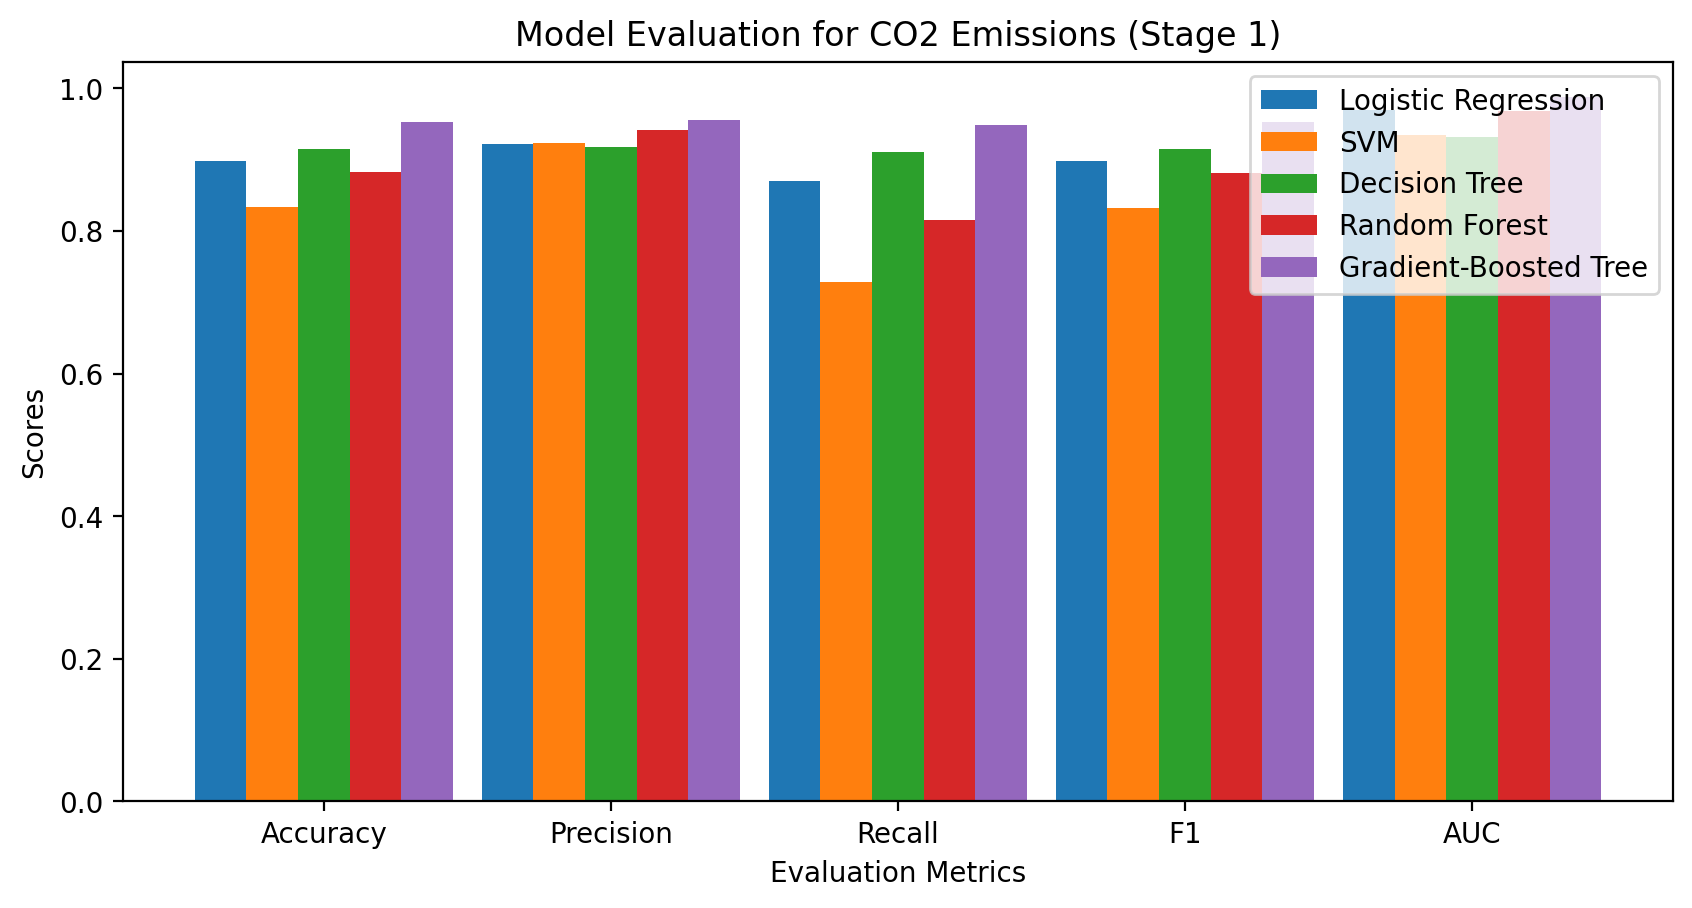

In [104]:
fig, ax = plt.subplots()

scores_emissions_clf_df.transpose().plot.bar(ax=ax, figsize=(10, 4.8), rot=0, width=0.9)

ax.set_title("Model Evaluation for CO2 Emissions (Stage 1)")
ax.set_ylabel("Scores")
ax.set_xlabel("Evaluation Metrics")
plt.show()

#### Regression

In [105]:
scores_emissions_names = [
    "Linear Regression",
    "Lasso",
    "Ridge",
    "Decision Tree",
    "Random Forest",
    "Gradient-Boosted Tree",
]

scores_emissions_low = [
    evaluate(lr_emissions_low_pred, "emissions", "prediction"),
    evaluate(lasso_emissions_low_pred, "emissions", "prediction"),
    evaluate(ridge_emissions_low_pred, "emissions", "prediction"),
    evaluate(dt_emissions_low_pred, "emissions", "prediction"),
    evaluate(rf_emissions_low_pred, "emissions", "prediction"),
    evaluate(gbt_emissions_low_pred, "emissions", "prediction"),
]

scores_emissions_high = [
    evaluate(lr_emissions_high_pred, "emissions", "prediction"),
    evaluate(lasso_emissions_high_pred, "emissions", "prediction"),
    evaluate(ridge_emissions_high_pred, "emissions", "prediction"),
    evaluate(dt_emissions_high_pred, "emissions", "prediction"),
    evaluate(rf_emissions_high_pred, "emissions", "prediction"),
    evaluate(gbt_emissions_high_pred, "emissions", "prediction"),
]

scores_emissions_final = [
    evaluate(lr_emissions_fp, "emissions", "prediction"),
    evaluate(lasso_emissions_fp, "emissions", "prediction"),
    evaluate(ridge_emissions_fp, "emissions", "prediction"),
    evaluate(dt_emissions_fp, "emissions", "prediction"),
    evaluate(rf_emissions_fp, "emissions", "prediction"),
    evaluate(gbt_emissions_fp, "emissions", "prediction"),
]

In [106]:
scores_emissions_low_df = pd.DataFrame(
    scores_emissions_low,
    index=scores_emissions_names,
)
scores_emissions_low_df

,MAE,MAPE,MAD,MdAPE,MSE,RMSE,R2
Linear Regression,4921.662736,243.470080,2126.487440,54.690211,9.807743e+07,9903.405055,-0.641203
Lasso,5586.979569,269.753622,2521.558338,68.956138,6.565958e+07,8103.060137,-0.098731
Ridge,5764.898655,265.886207,2556.821617,71.287206,6.977245e+07,8352.990352,-0.167555
Decision Tree,3607.584106,145.238757,1785.000086,49.879557,3.321601e+07,5763.333485,0.444172
Random Forest,3773.177975,153.050530,1703.441092,48.451875,3.677633e+07,6064.349264,0.384594
Gradient-Boosted Tree,2537.211735,114.327606,1163.995812,32.691858,1.850813e+07,4302.107435,0.690290


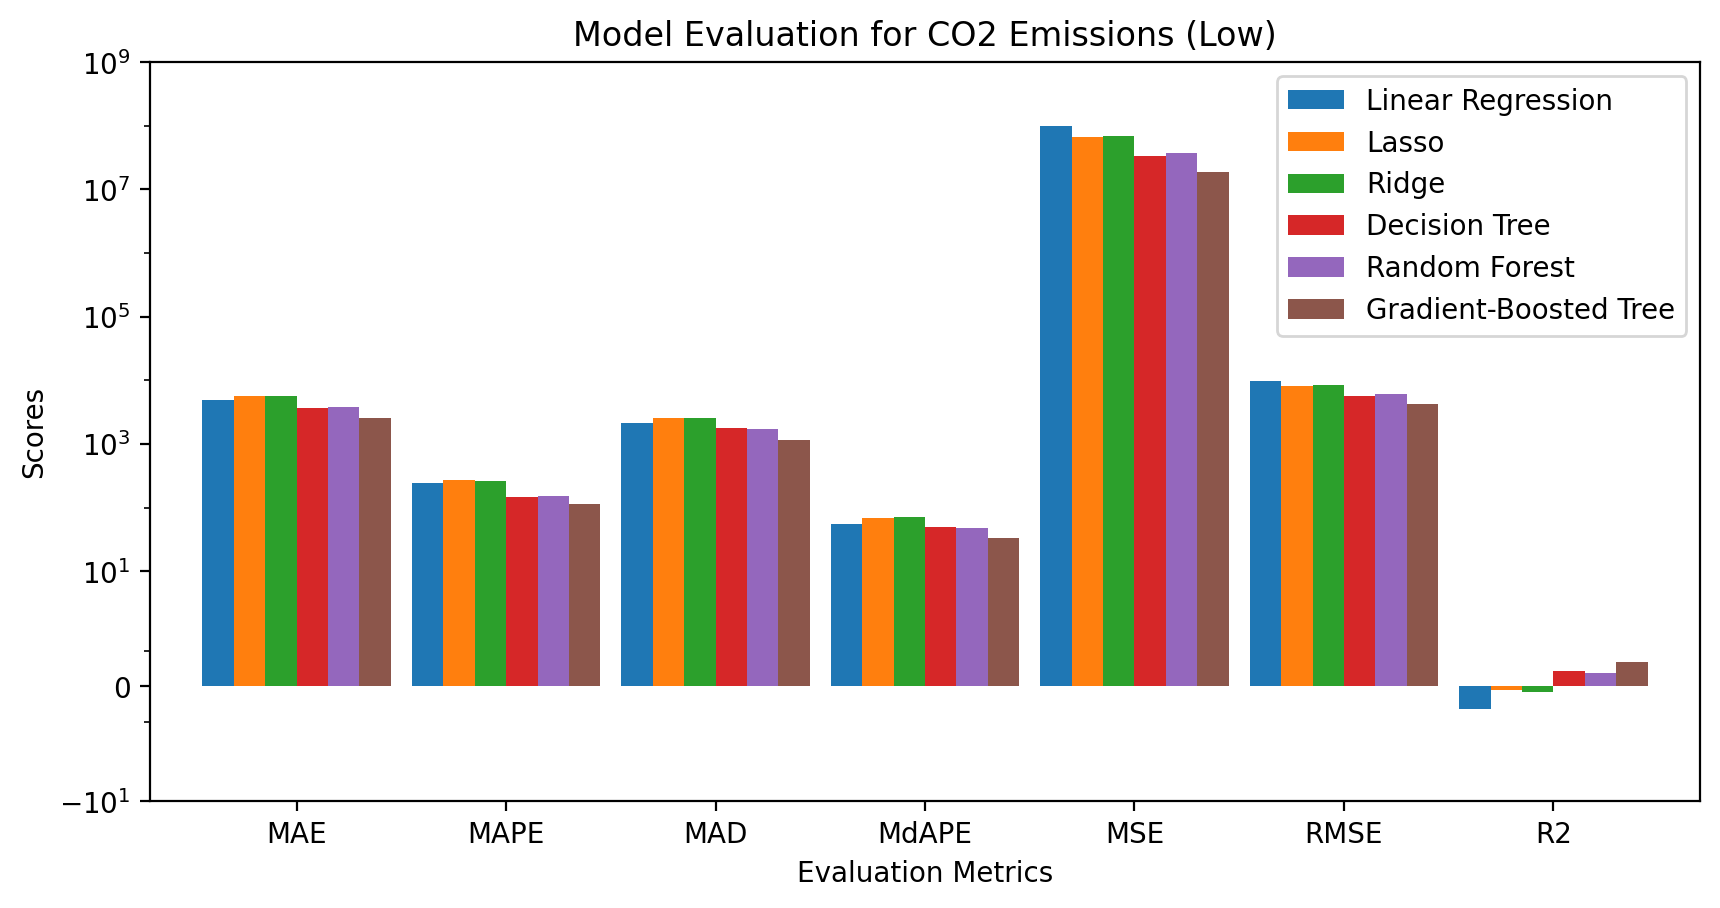

In [107]:
fig, ax = plt.subplots()

scores_emissions_low_df.transpose().plot.bar(ax=ax, figsize=(10, 4.8), rot=0, width=0.9)

ax.set_title("Model Evaluation for CO2 Emissions (Low)")
ax.set_ylabel("Scores")
ax.set_yscale("symlog")
ax.set_yticks([-10e2, -10, 0] + [10 * 10**i for i in range(0, 9, 2)])
ax.set_ylim(-10, 10e8)
ax.set_xlabel("Evaluation Metrics")
plt.show()

In [108]:
scores_emissions_high_df = pd.DataFrame(
    scores_emissions_high,
    index=scores_emissions_names,
)
scores_emissions_high_df

,MAE,MAPE,MAD,MdAPE,MSE,RMSE,R2
Linear Regression,5.871195e+06,113.125963,76169.050166,66.594078,4.067675e+15,6.377833e+07,-332.253111
Lasso,7.751297e+05,115.680400,88947.432243,84.714570,1.156774e+13,3.401138e+06,0.052288
Ridge,7.869198e+05,117.783036,89380.119977,86.513550,9.581646e+12,3.095423e+06,0.215003
Decision Tree,3.974213e+05,53.553837,37669.925853,35.905195,3.066483e+12,1.751138e+06,0.748772
Random Forest,3.284725e+05,45.666194,34416.460471,33.748759,2.035589e+12,1.426741e+06,0.833230
Gradient-Boosted Tree,2.844036e+05,23.057149,17121.777396,15.992231,2.074400e+12,1.440278e+06,0.830050


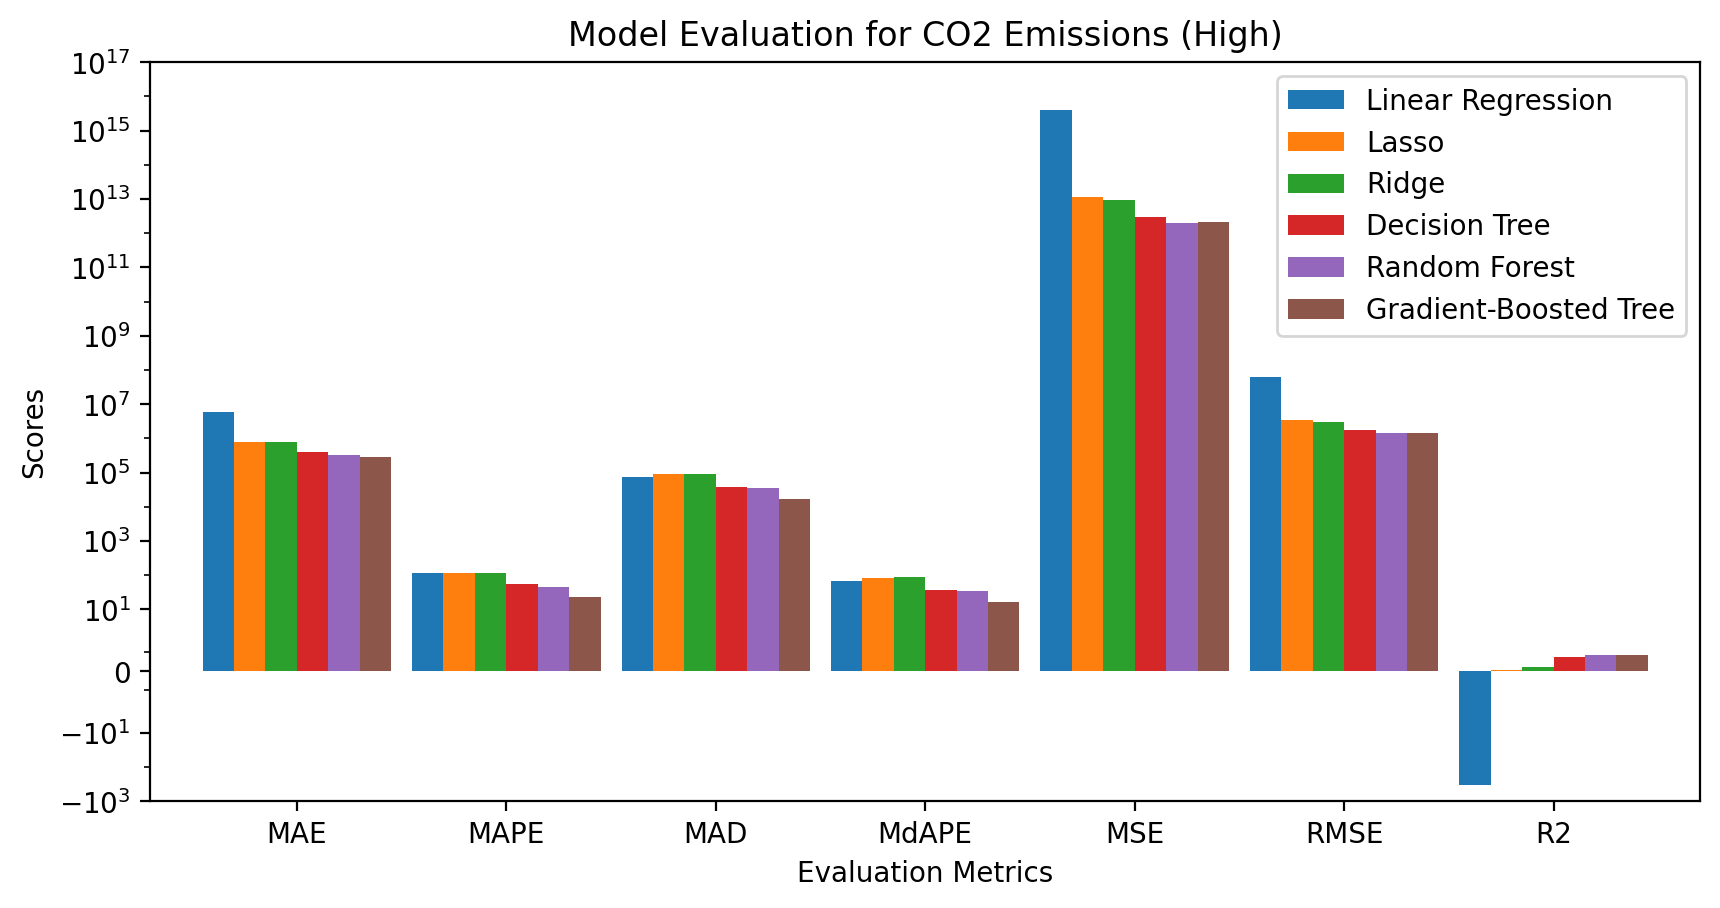

In [109]:
fig, ax = plt.subplots()

scores_emissions_high_df.transpose().plot.bar(
    ax=ax, figsize=(10, 4.8), rot=0, width=0.9
)

ax.set_title("Model Evaluation for CO2 Emissions (High)")
ax.set_ylabel("Scores")
ax.set_yscale("symlog")
ax.set_yticks([-10e2, -10, 0] + [10 * 10**i for i in range(0, 17, 2)])
ax.set_ylim(-1e3, 10e16)
ax.set_xlabel("Evaluation Metrics")
plt.show()

In [110]:
scores_emissions_final_df = pd.DataFrame(
    scores_emissions_final,
    index=scores_emissions_names,
)
scores_emissions_final_df

,MAE,MAPE,MAD,MdAPE,MSE,RMSE,R2
Linear Regression,2.937797e+06,199.145510,15625.182653,64.481367,2.032222e+15,4.508018e+07,-321.454556
Lasso,3.916681e+05,211.239252,19552.936921,75.089909,5.779512e+12,2.404061e+06,0.082960
Ridge,3.977558e+05,212.472291,21606.965267,76.086265,4.787292e+12,2.187988e+06,0.240396
Decision Tree,2.016161e+05,109.494211,8555.518853,44.034078,1.532141e+12,1.237797e+06,0.756894
Random Forest,1.673357e+05,109.558092,9911.771399,42.025646,1.017107e+12,1.008517e+06,0.838615
Gradient-Boosted Tree,1.443381e+05,76.719504,4988.516022,22.767942,1.036452e+12,1.018063e+06,0.835545


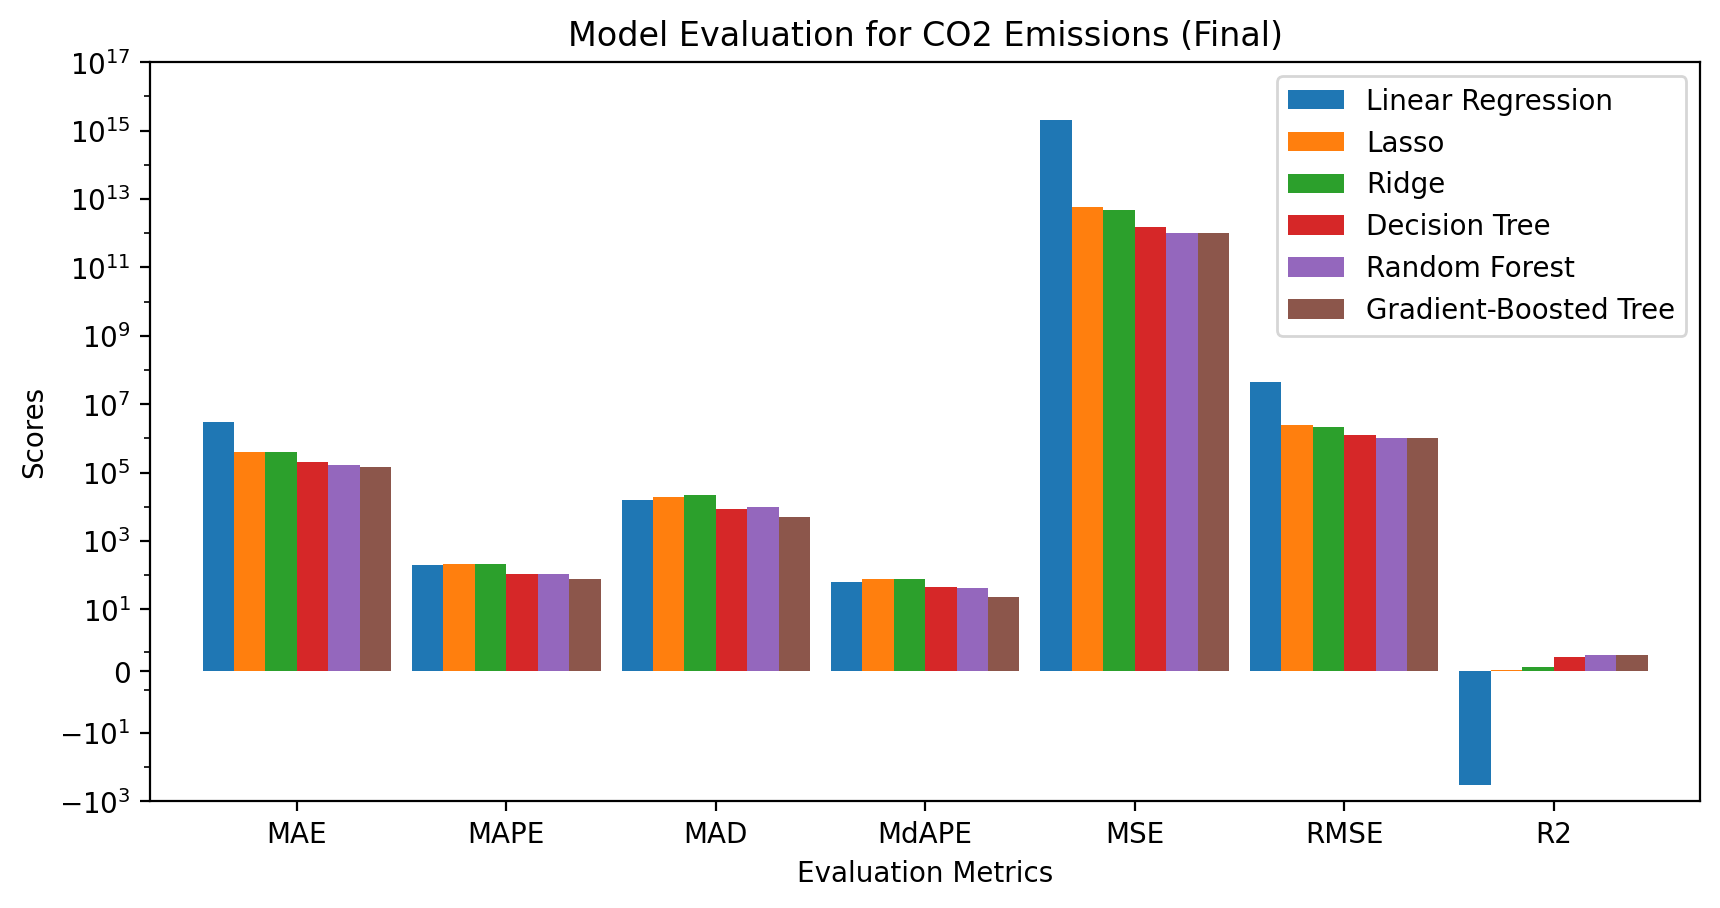

In [148]:
fig, ax = plt.subplots()

scores_emissions_final_df.transpose().plot.bar(ax=ax, figsize=(10, 4.8), rot=0, width=0.9)

ax.set_title("Model Evaluation for CO2 Emissions (Final)")
ax.set_ylabel("Scores")
ax.set_yscale("symlog")
ax.set_yticks([-10e2, -10, 0] + [10 * 10**i for i in range(0, 17, 2)])
ax.set_ylim(-1e3, 10e16)
ax.set_xlabel("Evaluation Metrics")
plt.show()

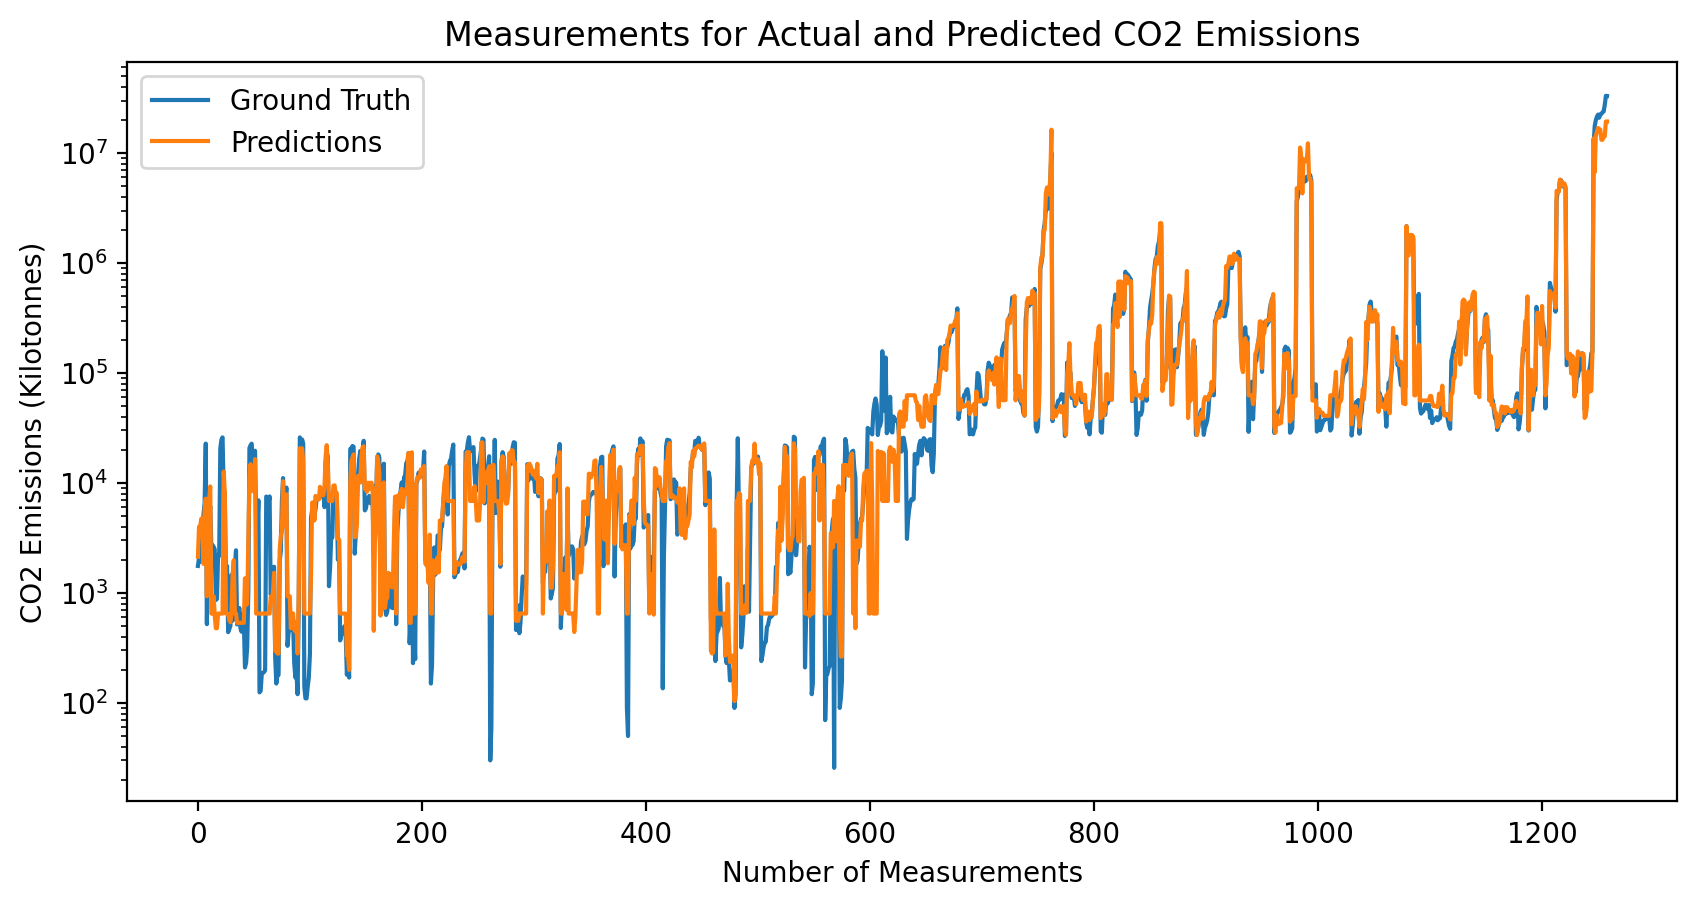

In [111]:
def plot_emissions_predictions_comparison():
    y1 = gbt_emissions_fp.select("emissions").rdd.flatMap(lambda x: x).collect()  # fmt: skip
    y2 = gbt_emissions_fp.select("prediction").rdd.flatMap(lambda x: x).collect()  # fmt: skip

    x = range(len(y1))

    plt.figure(figsize=(10, 4.8))

    plt.plot(x, y1, label="Ground Truth")
    plt.plot(x, y2, label="Predictions")

    plt.title("Measurements for Actual and Predicted CO2 Emissions")
    plt.ylabel("CO2 Emissions (Kilotonnes)")
    plt.xlabel("Number of Measurements")
    plt.yscale("log")
    plt.legend()
    plt.show()


plot_emissions_predictions_comparison()

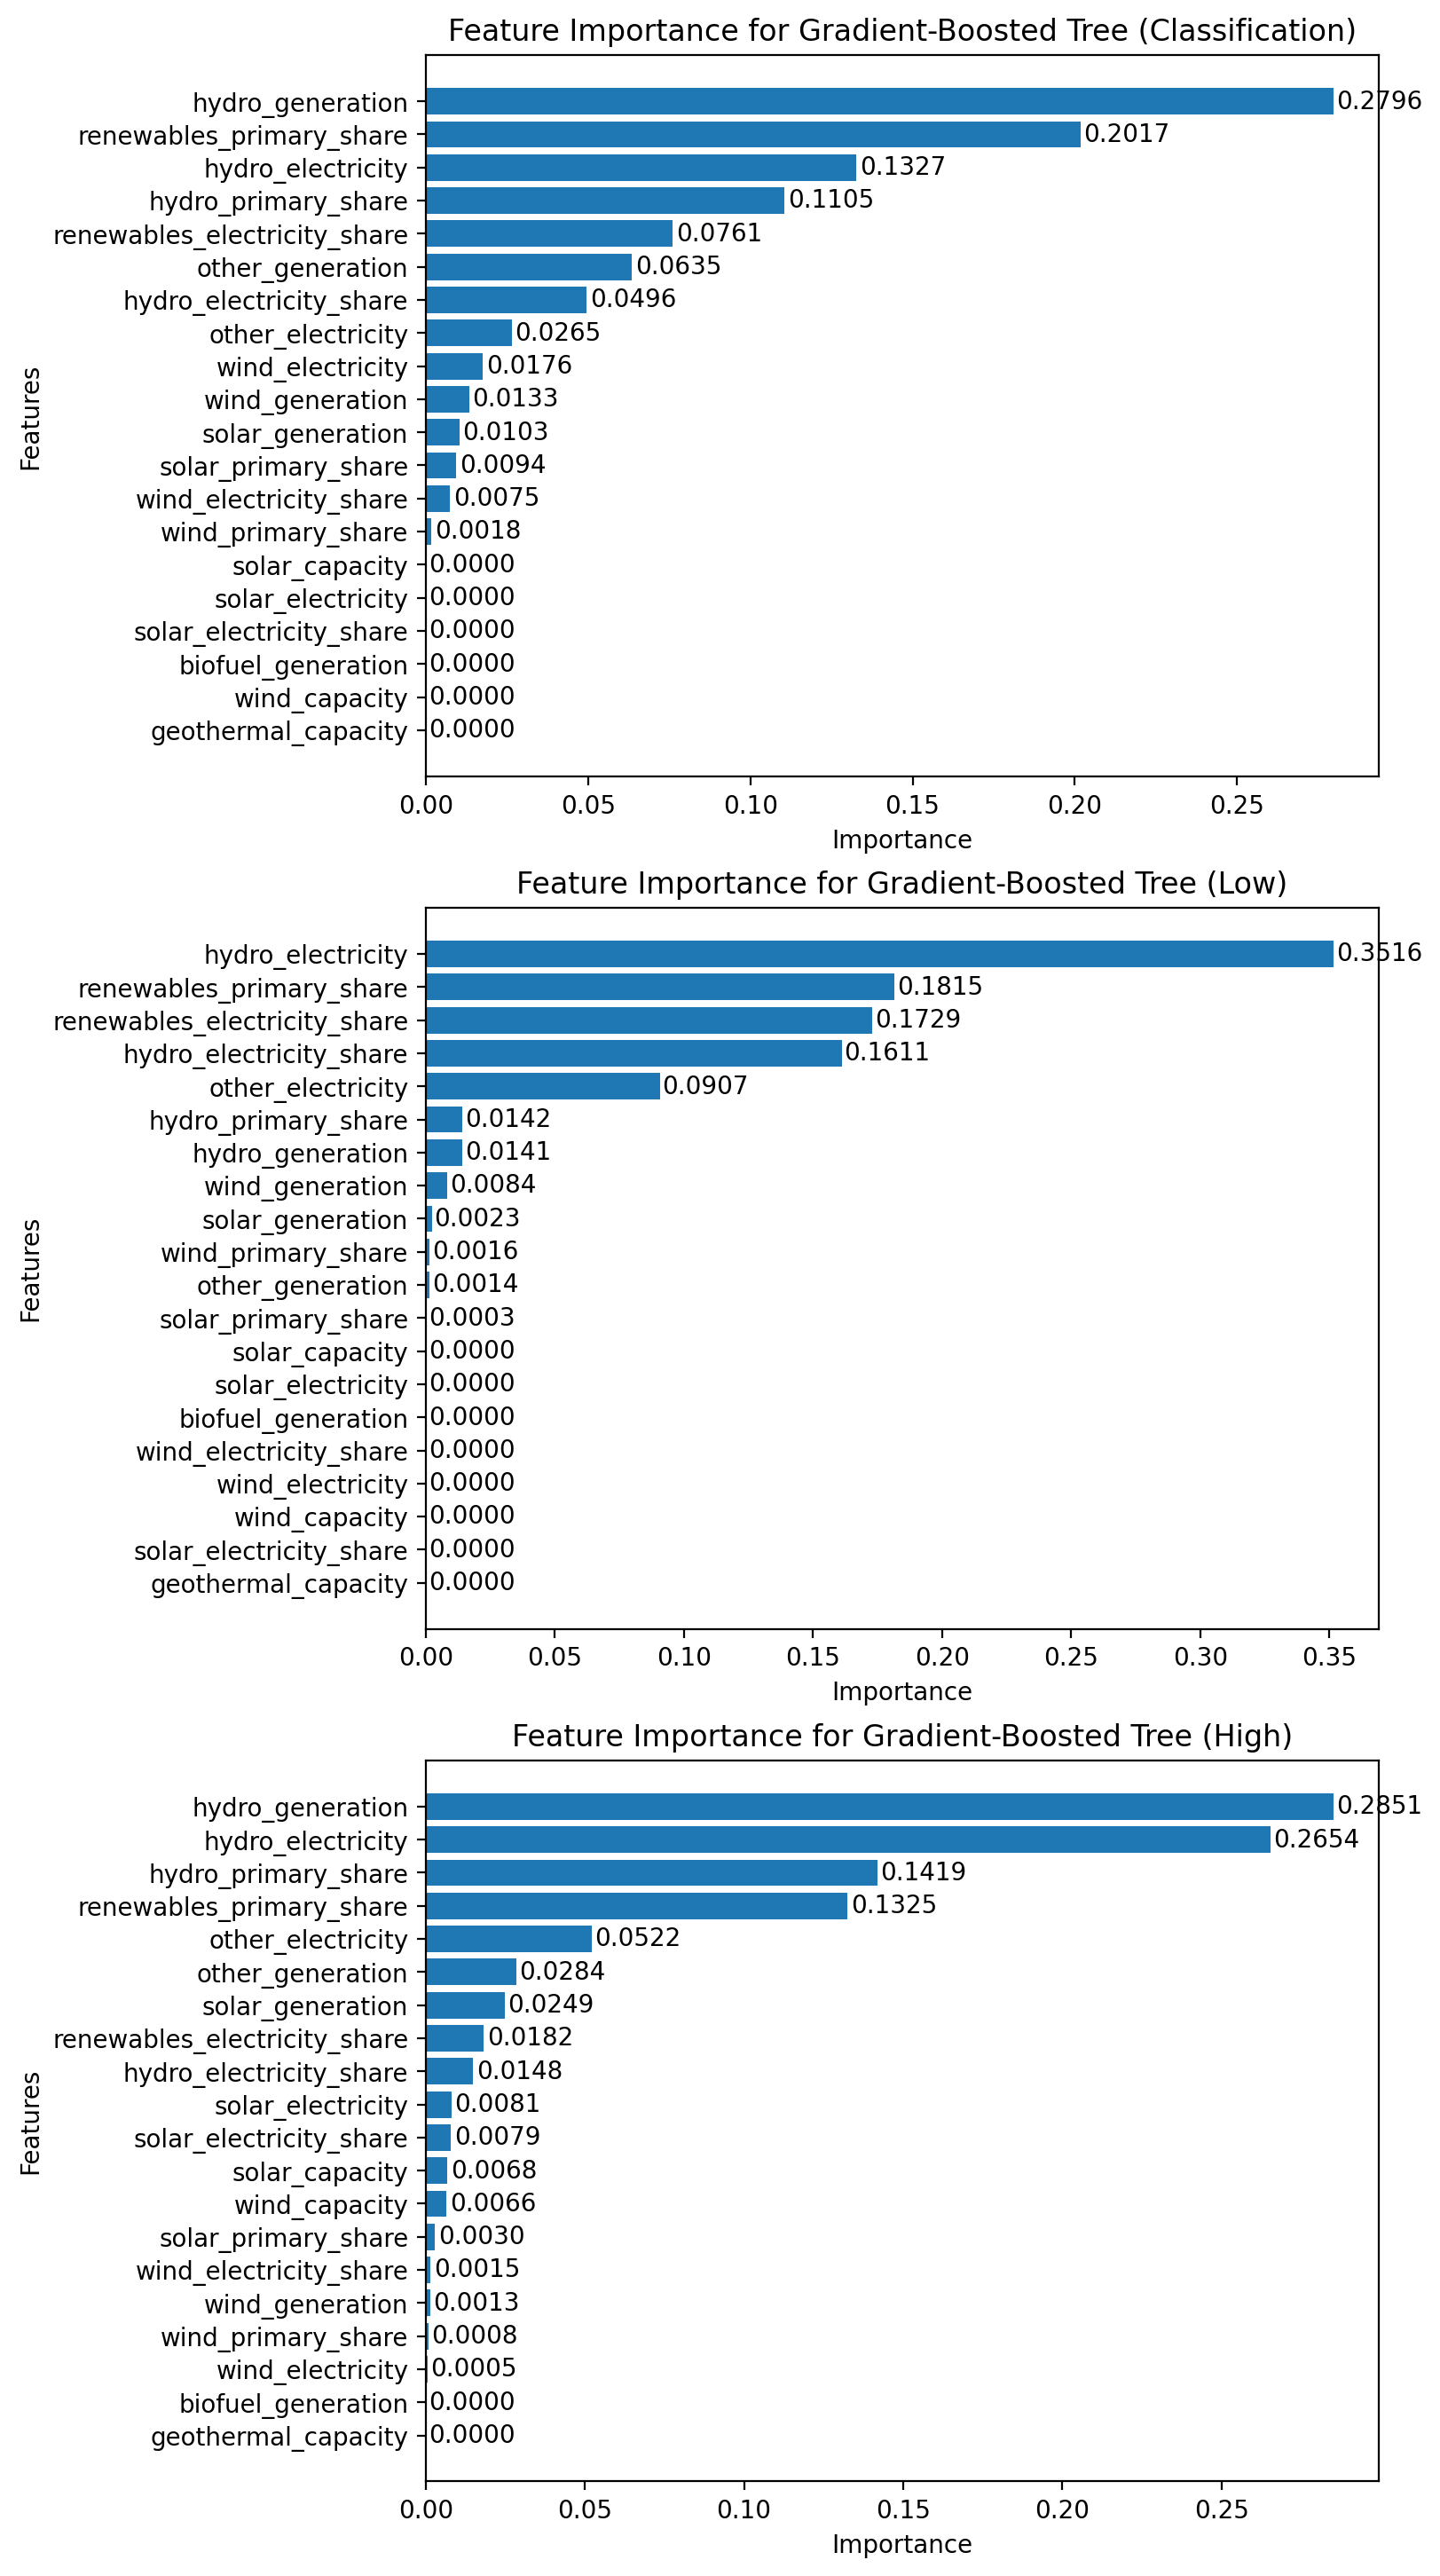

In [112]:
def plot_emissions_feature_importance():
    feature_names = df_joined_emissions.columns[3:23]

    fig = plt.figure(figsize=(8, 14.4), constrained_layout=True)

    # Classification
    df_clf = pd.DataFrame(zip(feature_names, gbtc_emissions_model.featureImportances))
    df_clf.sort_values(by=1, inplace=True)

    ax1 = fig.add_subplot(311)
    ax1.barh(df_clf[0], df_clf[1])

    for idx, value in enumerate(df_clf[1]):
        ax1.text(value + 0.001, idx, f"{value:.4f}", va="center")

    ax1.set_title("Feature Importance for Gradient-Boosted Tree (Classification)")
    ax1.set_ylabel("Features")
    ax1.set_xlabel("Importance")

    # Regression (Low)
    df_low = pd.DataFrame(zip(feature_names, gbt_emissions_low.featureImportances))
    df_low.sort_values(by=1, inplace=True)

    ax2 = fig.add_subplot(312)
    ax2.barh(df_low[0], df_low[1])

    for idx, value in enumerate(df_low[1]):
        ax2.text(value + 0.001, idx, f"{value:.4f}", va="center")

    ax2.set_title("Feature Importance for Gradient-Boosted Tree (Low)")
    ax2.set_ylabel("Features")
    ax2.set_xlabel("Importance")

    # Regression (High)
    df_high = pd.DataFrame(zip(feature_names, gbt_emissions_high.featureImportances))
    df_high.sort_values(by=1, inplace=True)

    ax3 = fig.add_subplot(313)
    ax3.barh(df_high[0], df_high[1])

    for idx, value in enumerate(df_high[1]):
        ax3.text(value + 0.001, idx, f"{value:.4f}", va="center")

    ax3.set_title("Feature Importance for Gradient-Boosted Tree (High)")
    ax3.set_ylabel("Features")
    ax3.set_xlabel("Importance")

    plt.show()


plot_emissions_feature_importance()

## GDP

### Data Loading

In [113]:
gdp_files = [
    "s3a://datasets/world_gdp/gdp.csv",
    "s3a://datasets/world_gdp/gdp_growth.csv",
    "s3a://datasets/world_gdp/gdp_per_capita.csv",
    "s3a://datasets/world_gdp/gdp_per_capita_growth.csv",
    "s3a://datasets/world_gdp/gdp_ppp.csv",
    "s3a://datasets/world_gdp/gdp_ppp_per_capita.csv",
]

df_gdp = spark.read.csv(gdp_files[0], **options).cache()
df_gdp_growth = spark.read.csv(gdp_files[1], **options).cache()

df_gdp_pc = spark.read.csv(gdp_files[2], **options).cache()
df_gdp_pc_growth = spark.read.csv(gdp_files[3], **options).cache()

df_gdp_ppp = spark.read.csv(gdp_files[4], **options).cache()
df_gdp_ppp_pc = spark.read.csv(gdp_files[5], **options).cache()

### Data Cleaning

In [114]:
df_gdp_melted = df_gdp.melt(
    ids=["Country Name", "Code"],
    values=df_gdp.columns[2:-1],
    variableColumnName="Year",
    valueColumnName="gdp",
).cache()

In [115]:
df_gdp_growth_melted = (
    df_gdp_growth.withColumn("1960", F.col("1960").cast("double"))
    .melt(
        ids=["Country Name", "Code"],
        values=df_gdp_growth.columns[2:-1],
        variableColumnName="Year",
        valueColumnName="gdp_growth",
    )
    .cache()
)

In [116]:
df_gdp_pc_melted = df_gdp_pc.melt(
    ids=["Country Name", "Code"],
    values=df_gdp_pc.columns[2:-1],
    variableColumnName="Year",
    valueColumnName="gdp_per_capita",
).cache()

In [117]:
df_gdp_pc_growth_melted = (
    df_gdp_pc_growth.withColumn("1960", F.col("1960").cast("double"))
    .melt(
        ids=["Country Name", "Code"],
        values=df_gdp_pc_growth.columns[2:-1],
        variableColumnName="Year",
        valueColumnName="gdp_per_capita_growth",
    )
    .cache()
)

In [118]:
for column in df_gdp_ppp.columns[2:32]:
    df_gdp_ppp = df_gdp_ppp.withColumn(column, F.col(column).cast("double"))

df_gdp_ppp_melted = df_gdp_ppp.melt(
    ids=["Country Name", "Code"],
    values=df_gdp_ppp.columns[2:-1],
    variableColumnName="Year",
    valueColumnName="gdp_ppp",
).cache()

In [119]:
for column in df_gdp_ppp_pc.columns[2:32]:
    df_gdp_ppp_pc = df_gdp_ppp_pc.withColumn(column, F.col(column).cast("double"))  # fmt: skip

df_gdp_ppp_pc_melted = df_gdp_ppp_pc.melt(
    ids=["Country Name", "Code"],
    values=df_gdp_ppp_pc.columns[2:-1],
    variableColumnName="Year",
    valueColumnName="gdp_ppp_growth",
).cache()

In [120]:
gdp_codes = [
    df_gdp_growth_melted.Code,
    df_gdp_pc_melted.Code,
    df_gdp_pc_growth_melted.Code,
    df_gdp_ppp_melted.Code,
    df_gdp_ppp_pc_melted.Code,
]

df_gdp_joined = (
    df_gdp_melted.join(
        other=df_gdp_growth_melted,
        on=["Country Name", "Year"],
        how="outer",
    )
    .join(
        other=df_gdp_pc_melted,
        on=["Country Name", "Year"],
        how="outer",
    )
    .join(
        other=df_gdp_pc_growth_melted,
        on=["Country Name", "Year"],
        how="outer",
    )
    .join(
        other=df_gdp_ppp_melted,
        on=["Country Name", "Year"],
        how="outer",
    )
    .join(
        other=df_gdp_ppp_pc_melted,
        on=["Country Name", "Year"],
        how="outer",
    )
    .withColumn("Year", F.col("Year").cast("integer"))
    .withColumnRenamed("Country Name", "Entity")
    .drop(*gdp_codes)
    .cache()
)

In [121]:
entity_map = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Congo, Dem. Rep.": "Democratic Republic of Congo",
    "Congo, Rep.": "Congo",
    "Czech Republic": "Czechia",
    "Egypt, Arab Rep.": "Egypt",
    "Faroe Islands": "Faeroe Islands",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macao",
    "Russian Federation": "Russia",
    "Slovak Republic": "Slovakia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Lucia": "Saint Lucia",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "Timor",
    "Venezuela, RB": "Venezuela",
    "Yemen, Rep.": "Yemen",
    "Virgin Islands (U.S.)": "United States Virgin Islands",
}

df_gdp_joined_fixed = df_gdp_joined.replace(entity_map, subset="Entity")

In [122]:
countries_gdp = (
    df_gdp_joined_fixed.select("Entity").distinct().rdd.map(lambda x: x[0]).collect()
)

In [123]:
# Countries without GDP data
countries_no_gdp = sorted(set(countries).difference(set(countries_gdp)))
print(countries_no_gdp)

['Cook Islands', 'Falkland Islands', 'French Guiana', 'Guadeloupe', 'Martinique', 'Montserrat', 'Niue', 'Palestine', 'Reunion', 'Saint Helena', 'Saint Pierre and Miquelon', 'Taiwan', 'USSR', 'Western Sahara']


### Data Integration

In [124]:
df_joined_emissions_gdp = (
    df_joined_emissions.join(
        other=df_gdp_joined_fixed,
        on=["Entity", "Year"],
        how="left",
    )
    .drop(df_gdp_joined_fixed.Code)
    .cache()
)

### Data Preprocessing

In [125]:
def preprocess_gdp_regression(fit):
    df_joined_emissions_gdp_filled = (
        df_joined_emissions_gdp.filter("gdp_per_capita IS NOT NULL")
        .fillna(-1)
        .withColumn("gdp_per_capita", F.log1p("gdp_per_capita"))
    )

    features = df_joined_emissions_gdp_filled.columns[3:-7]

    if fit:
        assemblers_1 = [
            VectorAssembler(inputCols=[feature], outputCol=f"{feature}_vt")
            for feature in features
        ]

        scalers = [
            StandardScaler(
                inputCol=f"{feature}_vt",
                outputCol=f"{feature}_scaled",
                withMean=True,
                withStd=True,
            )
            for feature in features
        ]

        assemblers_2 = [
            VectorAssembler(
                inputCols=[f"{feature}_scaled" for feature in features],
                outputCol="features",
            ),
        ]

        pipeline = Pipeline(stages=assemblers_1 + scalers + assemblers_2)
        model = pipeline.fit(df_joined_emissions_gdp_filled)
        model.write().overwrite().save("models/preprocess_gdp_regression")
    else:
        model = PipelineModel.load("models/preprocess_gdp_regression")

    return model.transform(df_joined_emissions_gdp_filled).drop(
        *features,
        *[f"{feature}_vt" for feature in features],
        *[f"{feature}_scaled" for feature in features],
    )

In [126]:
df_joined_emissions_gdp_filled_scaled = preprocess_gdp_regression(fit=False)

### Data Formatting

In [127]:
train_gdp, test_gdp = df_joined_emissions_gdp_filled_scaled.randomSplit(
    [0.8, 0.2],
    seed=12345,
)

### Modelling

In [128]:
tk.start("linear_regression_gdp")
tracemalloc.start()

lr_gdp = LinearRegression(featuresCol="features", labelCol="gdp_per_capita")
lr_gdp_model = lr_gdp.fit(train_gdp)

mk.record("linear_regression_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("linear_regression_gdp")
tracemalloc.stop()

In [129]:
lr_gdp_predictions = (
    lr_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

In [130]:
tk.start("lasso_gdp")
tracemalloc.start()

lasso_gdp = LinearRegression(
    featuresCol="features",
    labelCol="gdp_per_capita",
    elasticNetParam=1.0,
    regParam=0.3,
)
lasso_gdp_model = lasso_gdp.fit(train_gdp)

mk.record("lasso_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("lasso_gdp")
tracemalloc.stop()

In [131]:
lasso_gdp_predictions = (
    lasso_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

In [132]:
tk.start("ridge_gdp")
tracemalloc.start()

ridge_gdp = LinearRegression(
    featuresCol="features",
    labelCol="gdp_per_capita",
    elasticNetParam=0.0,
    regParam=7.5,
)
ridge_gdp_model = ridge_gdp.fit(train_gdp)

mk.record("ridge_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("ridge_gdp")
tracemalloc.stop()

In [133]:
ridge_gdp_predictions = (
    ridge_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

In [134]:
tk.start("decision_tree_gdp")
tracemalloc.start()

dt_gdp = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="gdp_per_capita",
    seed=12345,
)
dt_gdp_model = dt_gdp.fit(train_gdp)

mk.record("decision_tree_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("decision_tree_gdp")
tracemalloc.stop()

In [135]:
dt_gdp_predictions = (
    dt_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

In [136]:
tk.start("random_forest_gdp")
tracemalloc.start()

rf_gdp = RandomForestRegressor(
    featuresCol="features",
    labelCol="gdp_per_capita",
    seed=12345,
)
rf_gdp_model = rf_gdp.fit(train_gdp)

mk.record("random_forest_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("random_forest_gdp")
tracemalloc.stop()

In [137]:
rf_gdp_predictions = (
    rf_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

In [138]:
tk.start("gradient_boosted_tree_gdp")
tracemalloc.start()

gbt_gdp = GBTRegressor(featuresCol="features", labelCol="gdp_per_capita", seed=12345)
gbt_gdp_model = gbt_gdp.fit(train_gdp)

mk.record("gradient_boosted_tree_gdp", tracemalloc.get_traced_memory()[1])
tk.stop("gradient_boosted_tree_gdp")
tracemalloc.stop()

In [139]:
gbt_gdp_predictions = (
    gbt_gdp_model.transform(test_gdp)
    .withColumn("gdp_per_capita", F.expm1("gdp_per_capita"))
    .withColumn("prediction", F.expm1("prediction"))
)

### Evaluation

In [140]:
scores_gdp_names = [
    "Linear Regression",
    "Lasso",
    "Ridge",
    "Decision Tree",
    "Random Forest",
    "Gradient-Boosted Tree",
]

scores_gdp = [
    evaluate(lr_gdp_predictions, "gdp_per_capita", "prediction"),
    evaluate(lasso_gdp_predictions, "gdp_per_capita", "prediction"),
    evaluate(ridge_gdp_predictions, "gdp_per_capita", "prediction"),
    evaluate(dt_gdp_predictions, "gdp_per_capita", "prediction"),
    evaluate(rf_gdp_predictions, "gdp_per_capita", "prediction"),
    evaluate(gbt_gdp_predictions, "gdp_per_capita", "prediction"),
]

In [141]:
scores_gdp_df = pd.DataFrame(scores_gdp, index=scores_gdp_names)
scores_gdp_df

,MAE,MAPE,MAD,MdAPE,MSE,RMSE,R2
Linear Regression,9830.282670,212.987577,3082.748247,77.200003,7.182233e+08,26799.687864,-1.677677
Lasso,9401.440025,252.029825,3128.381877,84.332898,3.092539e+08,17585.617151,-0.152959
Ridge,9362.560830,244.241335,3040.275677,84.181294,3.074186e+08,17533.358045,-0.146117
Decision Tree,6695.959444,134.385226,2352.178249,63.675989,1.624526e+08,12745.688511,0.394345
Random Forest,6828.642389,130.438430,2399.682091,63.202926,1.709341e+08,13074.175647,0.362724
Gradient-Boosted Tree,5822.913848,105.515378,2103.138093,56.013621,1.192030e+08,10918.011551,0.555588


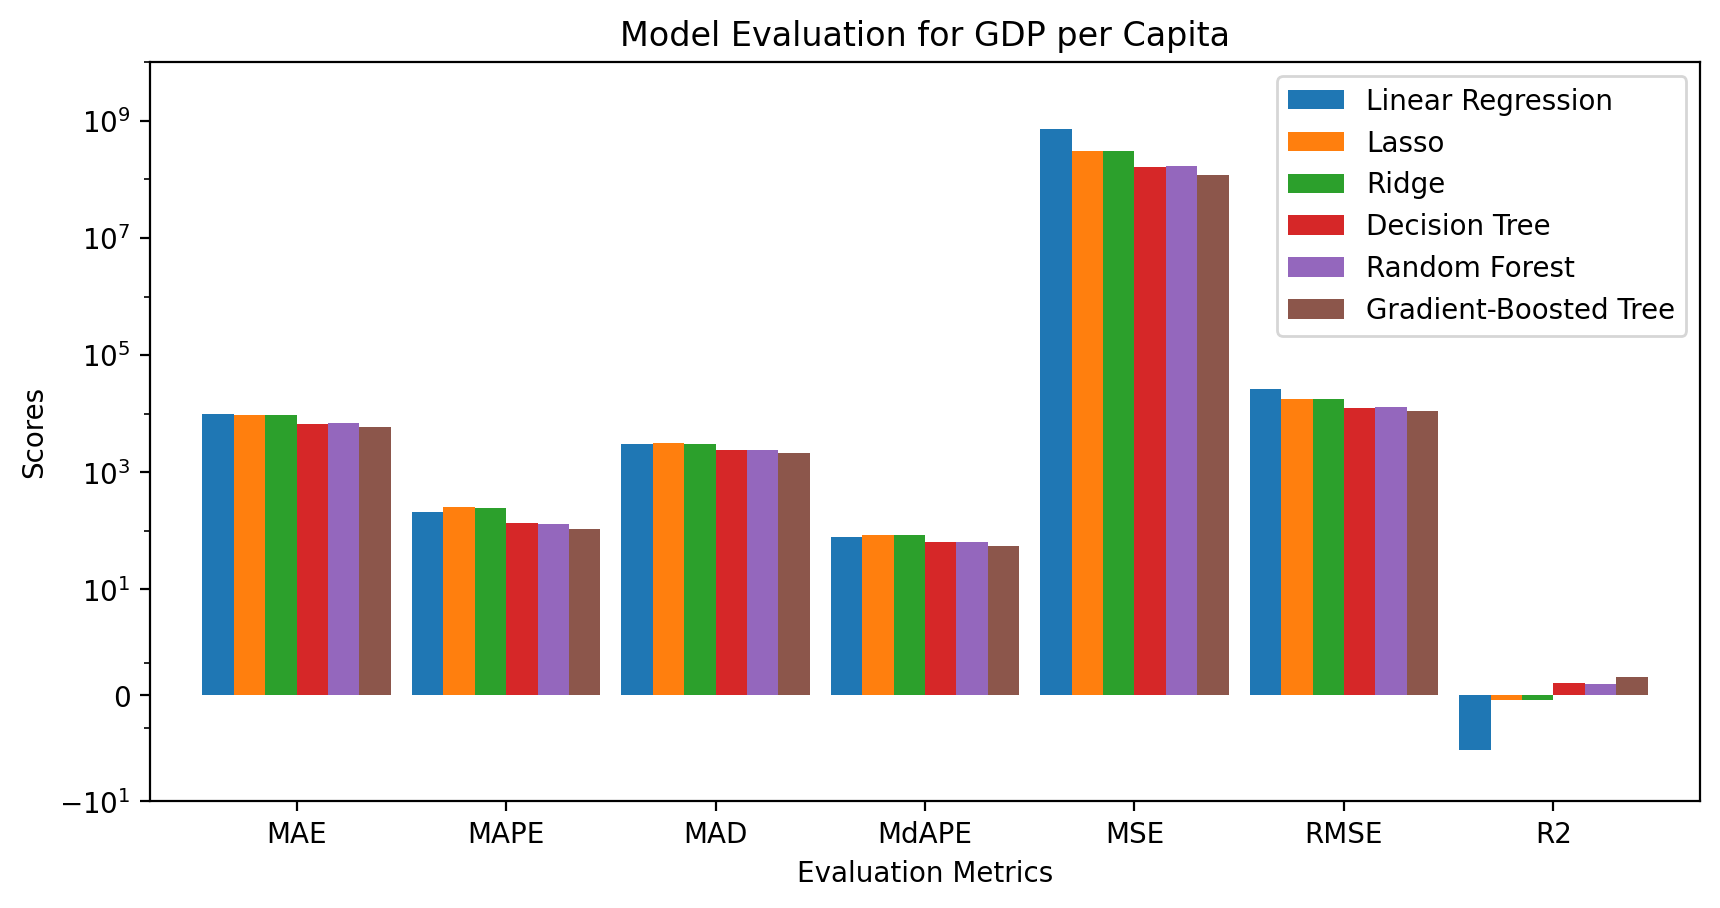

In [142]:
fig, ax = plt.subplots()

scores_gdp_df.transpose().plot.bar(ax=ax, figsize=(10, 4.8), rot=0, width=0.9)

ax.set_title("Model Evaluation for GDP per Capita")
ax.set_ylabel("Scores")
ax.set_yscale("symlog")
ax.set_yticks([-10, 0] + [10 * 10**i for i in range(0, 10, 2)])
ax.set_ylim(-10, 10e9)
ax.set_xlabel("Evaluation Metrics")
plt.show()

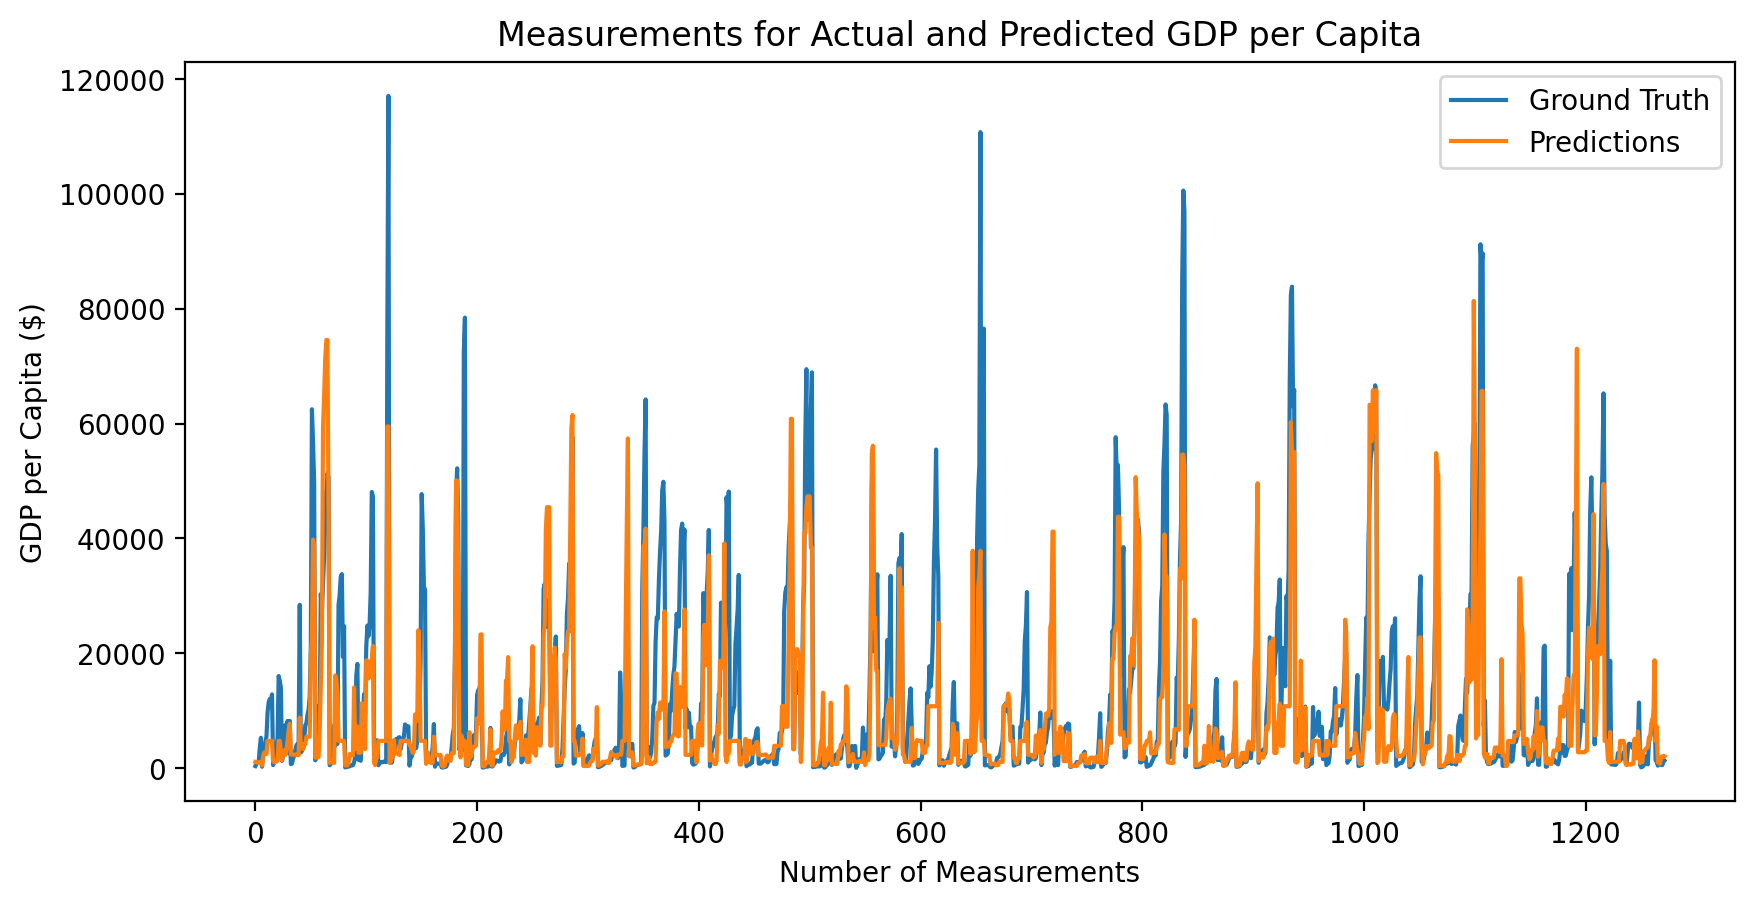

In [143]:
def plot_gdp_predictions_comparison():
    y1 = gbt_gdp_predictions.select("gdp_per_capita").rdd.flatMap(lambda x: x).collect()  # fmt: skip
    y2 = gbt_gdp_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    x = range(len(y1))

    plt.figure(figsize=(10, 4.8))

    plt.plot(x, y1, label="Ground Truth")
    plt.plot(x, y2, label="Predictions")

    plt.title("Measurements for Actual and Predicted GDP per Capita")
    plt.ylabel("GDP per Capita ($)")
    plt.xlabel("Number of Measurements")
    plt.legend()
    plt.show()


plot_gdp_predictions_comparison()

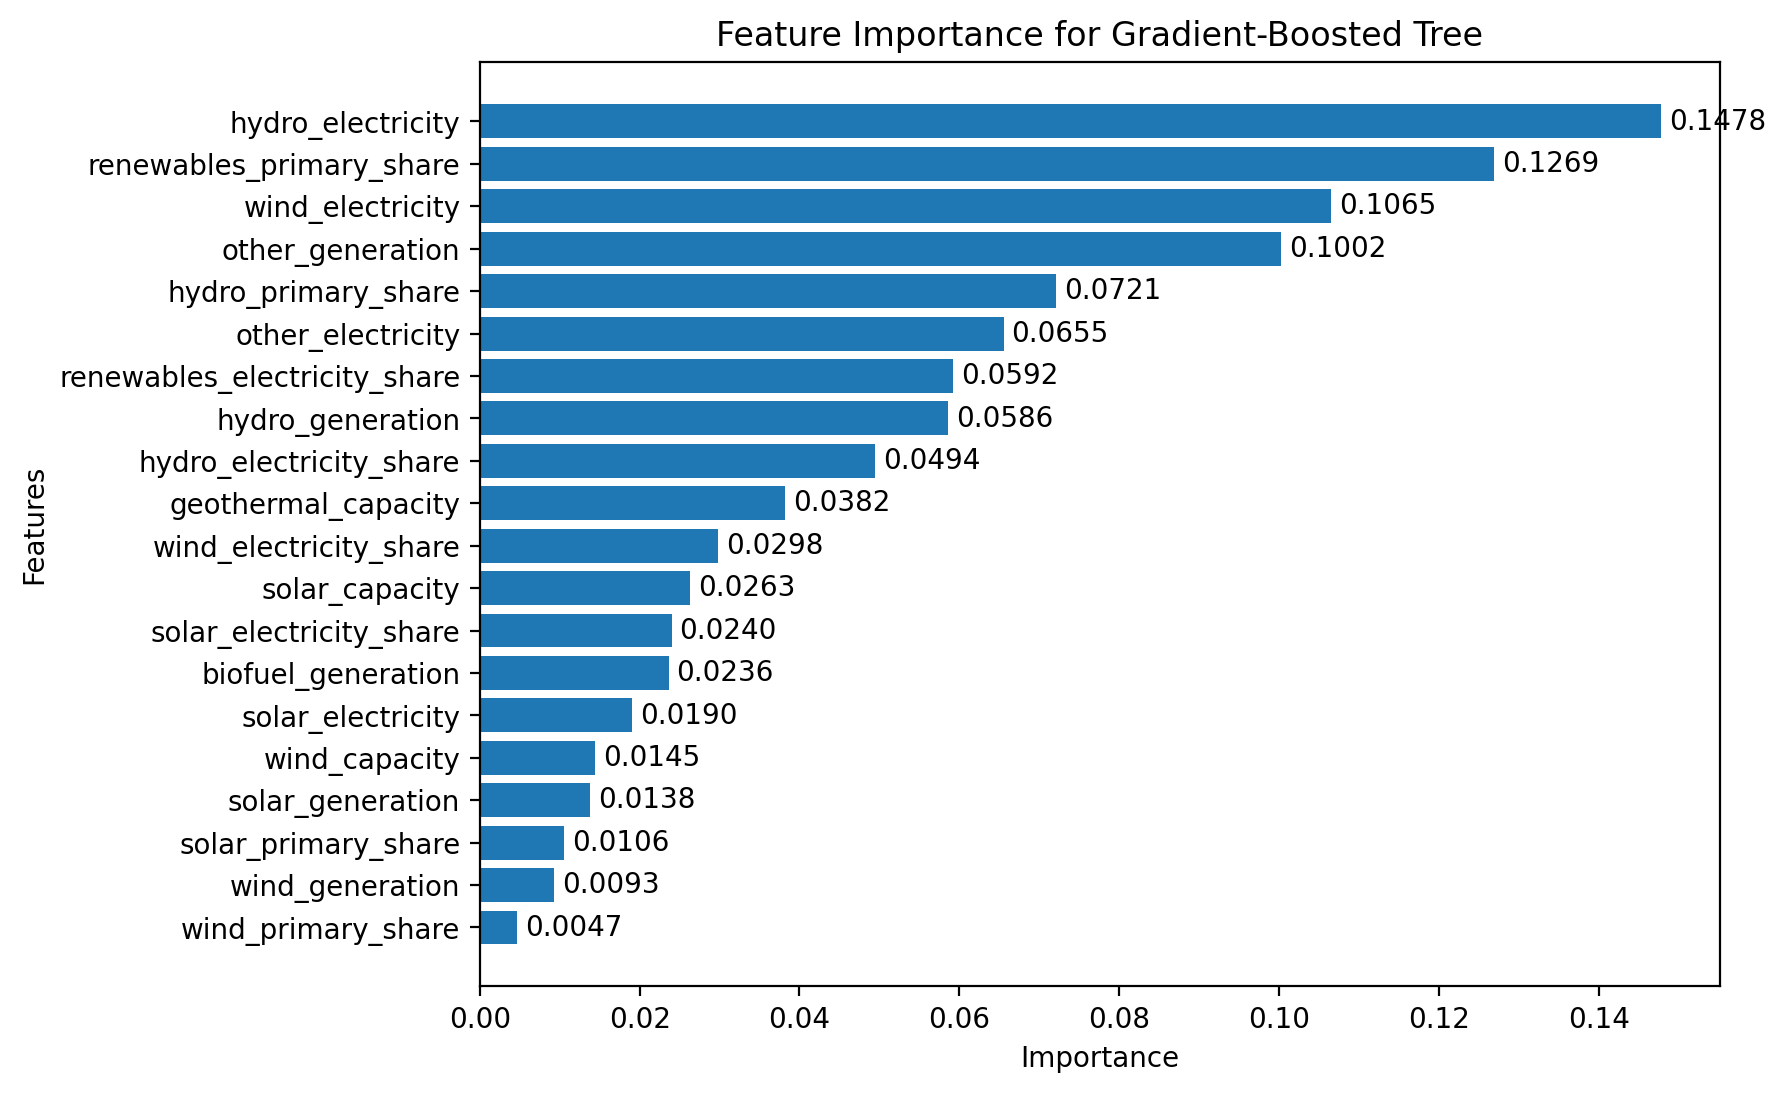

In [144]:
def plot_gdp_feature_importance():
    feature_names = df_joined_emissions_gdp.columns[3:-7]

    df = pd.DataFrame(zip(feature_names, gbt_gdp_model.featureImportances))
    df.sort_values(by=1, inplace=True)

    plt.figure(figsize=(8, 6))

    plt.barh(df[0], df[1])

    for idx, value in enumerate(df[1]):
        plt.text(value + 0.001, idx, f"{value:.4f}", va="center")

    plt.title("Feature Importance for Gradient-Boosted Tree")
    plt.ylabel("Features")
    plt.xlabel("Importance")
    plt.show()


plot_gdp_feature_importance()

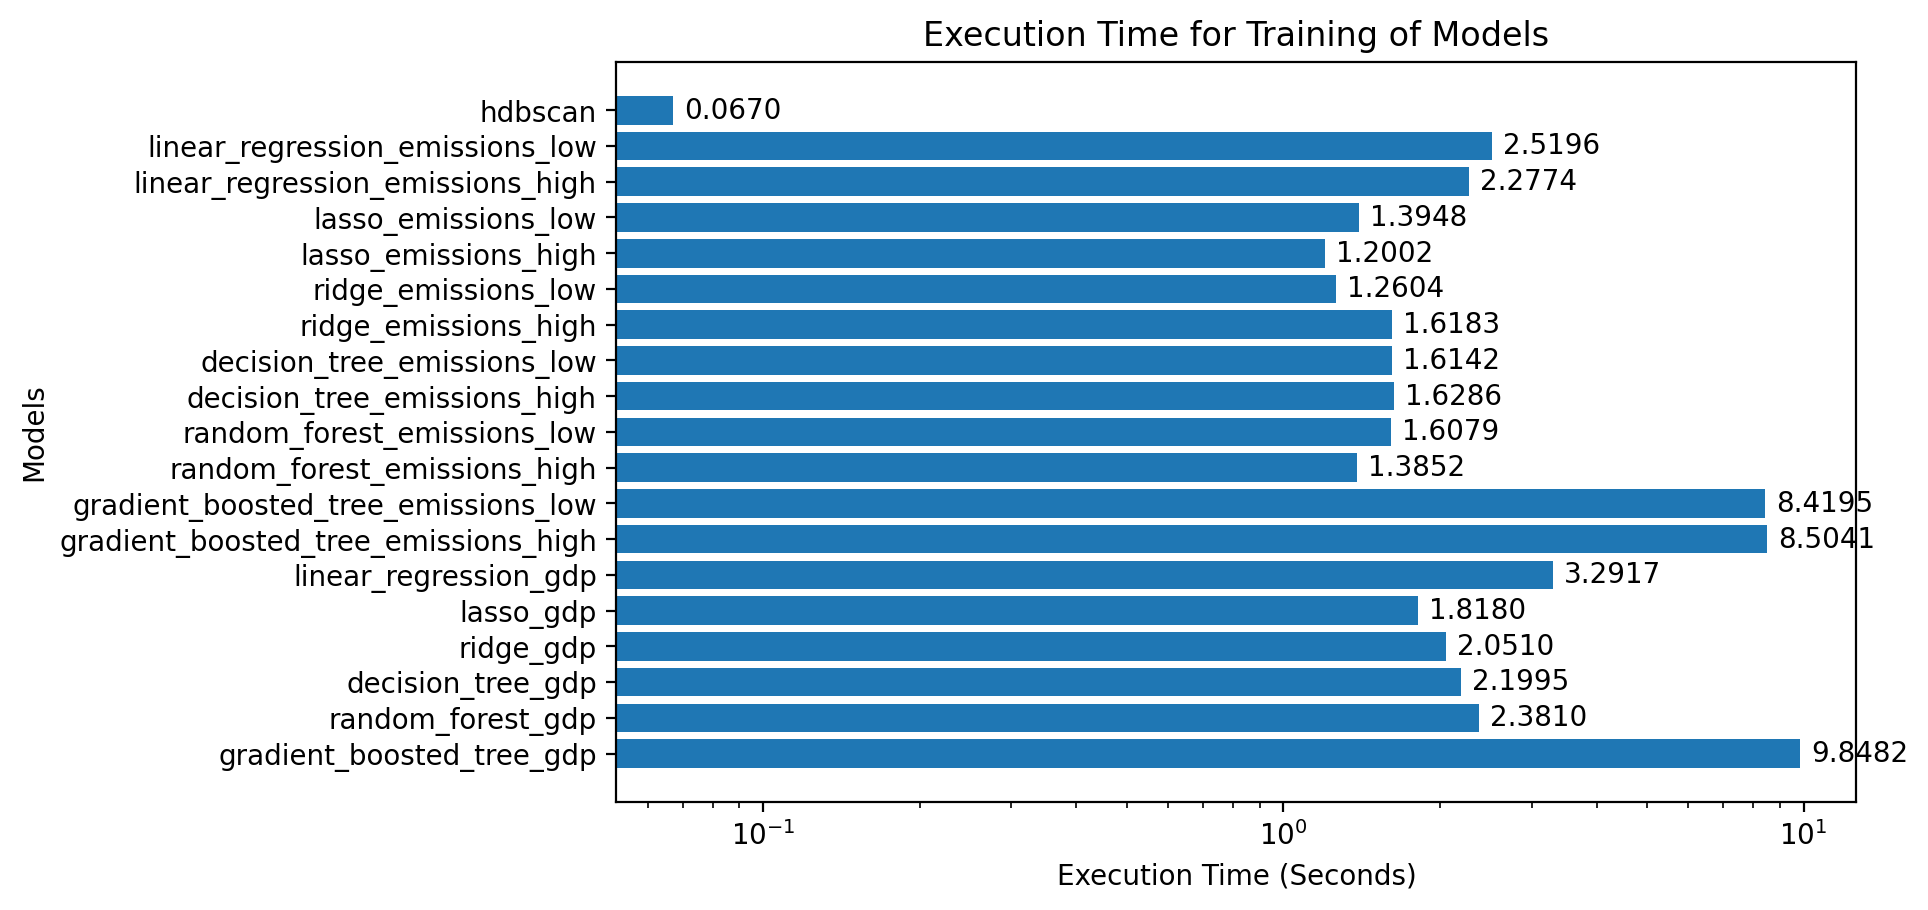

In [145]:
def plot_execution_time():
    df = pd.DataFrame(tk.durations.items())
    df[1] = df[1] / 1e9

    plt.figure(figsize=(8, 4.8))

    plt.barh(df[0], df[1])

    for idx, value in enumerate(df[1]):
        plt.text(value * 1.05, idx, f"{value:.4f}", va="center")

    plt.title("Execution Time for Training of Models")
    plt.ylabel("Models")
    plt.xlabel("Execution Time (Seconds)")
    plt.xscale("log")
    plt.gca().invert_yaxis()
    plt.show()


plot_execution_time()

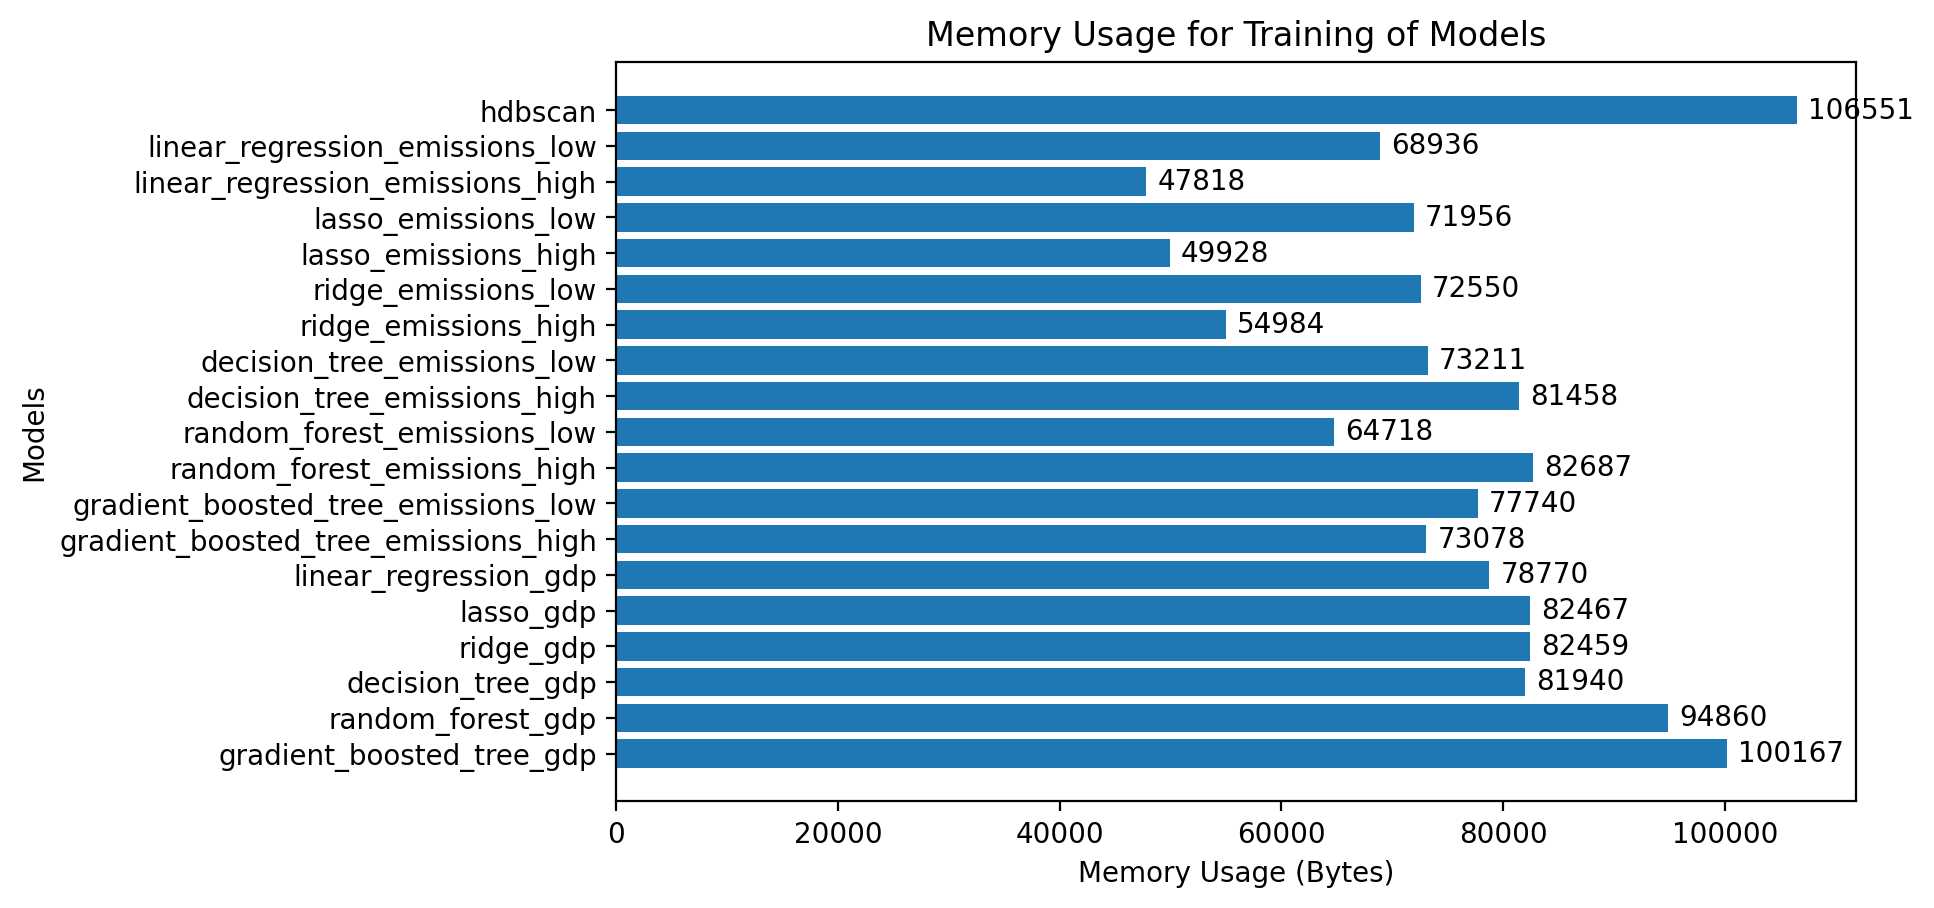

In [146]:
def plot_memory_usage():
    df = pd.DataFrame(mk.memory.items())

    plt.figure(figsize=(8, 4.8))

    plt.barh(df[0], df[1])

    for idx, value in enumerate(df[1]):
        plt.text(value + 1e3, idx, value, va="center")

    plt.title("Memory Usage for Training of Models")
    plt.ylabel("Models")
    plt.xlabel("Memory Usage (Bytes)")
    plt.gca().invert_yaxis()
    plt.show()


plot_memory_usage()